In [46]:
#importing all the needed liberary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
from IPython.display import display, HTML
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from tabulate import tabulate
from lightgbm import early_stopping, log_evaluation

In [74]:

# Loading the dataset
file_path = "household_data_15min_singleindex.csv"
df = pd.read_csv(file_path)

In [76]:
# Capturing df.info() output
buffer = io.StringIO()
df.info(buf=buffer)
info_str = buffer.getvalue()
print(df.columns)
# Creating styled HTML for info
info_html = f"""
<div style="
    background-color: #f9f9f9;
    padding: 20px;
    border-radius: 10px;
    font-family: 'Segoe UI', sans-serif;
    color: #333;
    margin-bottom: 20px;
    box-shadow: 0 2px 8px rgba(0,0,0,0.1);
">
    <h3 style="color: #4A90E2;">📊 DataFrame Info</h3>
    <pre style="white-space: pre-wrap;">{info_str}</pre>
</div>
"""

# Creating styled HTML for head
head_html = df.head().to_html(classes='styled-table', index=False)

# CSS styling
css = """
<style>
.styled-table {
    border-collapse: collapse;
    margin: 10px 0;
    font-size: 16px;
    font-family: 'Segoe UI', sans-serif;
    min-width: 400px;
    border-radius: 8px 8px 0 0;
    overflow: hidden;
    box-shadow: 0 0 10px rgba(0,0,0,0.1);
}
.styled-table thead tr {
    background-color: #4A90E2;
    color: #ffffff;
    text-align: left;
}
.styled-table th, .styled-table td {
    padding: 12px 15px;
}
.styled-table tbody tr {
    border-bottom: 1px solid #dddddd;
}
.styled-table tbody tr:nth-of-type(even) {
    background-color: #f3f3f3;
}
.styled-table tbody tr:last-of-type {
    border-bottom: 2px solid #4A90E2;
}
</style>
"""

# Displaying both
display(HTML(css + info_html + head_html))

Index(['utc_timestamp', 'cet_cest_timestamp', 'DE_KN_industrial1_grid_import',
       'DE_KN_industrial1_pv_1', 'DE_KN_industrial1_pv_2',
       'DE_KN_industrial2_grid_import', 'DE_KN_industrial2_pv',
       'DE_KN_industrial2_storage_charge',
       'DE_KN_industrial2_storage_decharge', 'DE_KN_industrial3_area_offices',
       'DE_KN_industrial3_area_room_1', 'DE_KN_industrial3_area_room_2',
       'DE_KN_industrial3_area_room_3', 'DE_KN_industrial3_area_room_4',
       'DE_KN_industrial3_compressor', 'DE_KN_industrial3_cooling_aggregate',
       'DE_KN_industrial3_cooling_pumps', 'DE_KN_industrial3_dishwasher',
       'DE_KN_industrial3_ev', 'DE_KN_industrial3_grid_import',
       'DE_KN_industrial3_machine_1', 'DE_KN_industrial3_machine_2',
       'DE_KN_industrial3_machine_3', 'DE_KN_industrial3_machine_4',
       'DE_KN_industrial3_machine_5', 'DE_KN_industrial3_pv_facade',
       'DE_KN_industrial3_pv_roof', 'DE_KN_industrial3_refrigerator',
       'DE_KN_industrial3_ventilation

In [78]:
df.isnull().mean().sort_values(ascending=False)

DE_KN_public2_grid_import              0.970802
DE_KN_public1_grid_import              0.881692
DE_KN_industrial2_storage_charge       0.746375
DE_KN_industrial2_storage_decharge     0.746375
DE_KN_residential2_freezer             0.733437
                                         ...   
DE_KN_residential3_washing_machine     0.205637
DE_KN_residential5_grid_import         0.198940
DE_KN_residential3_circulation_pump    0.136344
cet_cest_timestamp                     0.000000
utc_timestamp                          0.000000
Length: 71, dtype: float64

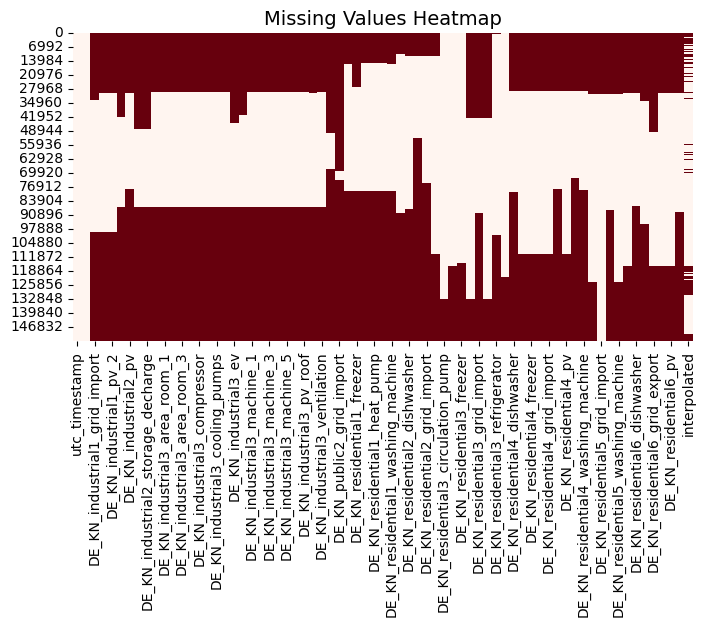

In [80]:
# Null value summary
null_summary = pd.DataFrame({
    'Total Missing': df.isnull().sum(),
    'Percent Missing (%)': (df.isnull().mean() * 100).round(2)
}).reset_index().rename(columns={'index': 'Column'})

# Styling HTML table
null_html = null_summary.to_html(classes='styled-table', index=False)

# CSS Styling
css = """
<style>
.styled-table {
    border-collapse: collapse;
    margin: 10px 0;
    font-size: 16px;
    font-family: 'Segoe UI', sans-serif;
    min-width: 400px;
    border-radius: 8px 8px 0 0;
    overflow: hidden;
    box-shadow: 0 0 10px rgba(0,0,0,0.1);
}
.styled-table thead tr {
    background-color: #e63946;
    color: #ffffff;
    text-align: left;
}
.styled-table th, .styled-table td {
    padding: 12px 15px;
}
.styled-table tbody tr {
    border-bottom: 1px solid #dddddd;
}
.styled-table tbody tr:nth-of-type(even) {
    background-color: #f3f3f3;
}
.styled-table tbody tr:last-of-type {
    border-bottom: 2px solid #e63946;
}
</style>
"""

# Displaying Null Summary Table
display(HTML(css + null_html))

# Optional: Visualing missing values as a heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df.isnull(), cbar=False, cmap='Reds')
plt.title('Missing Values Heatmap', fontsize=14)
plt.show()

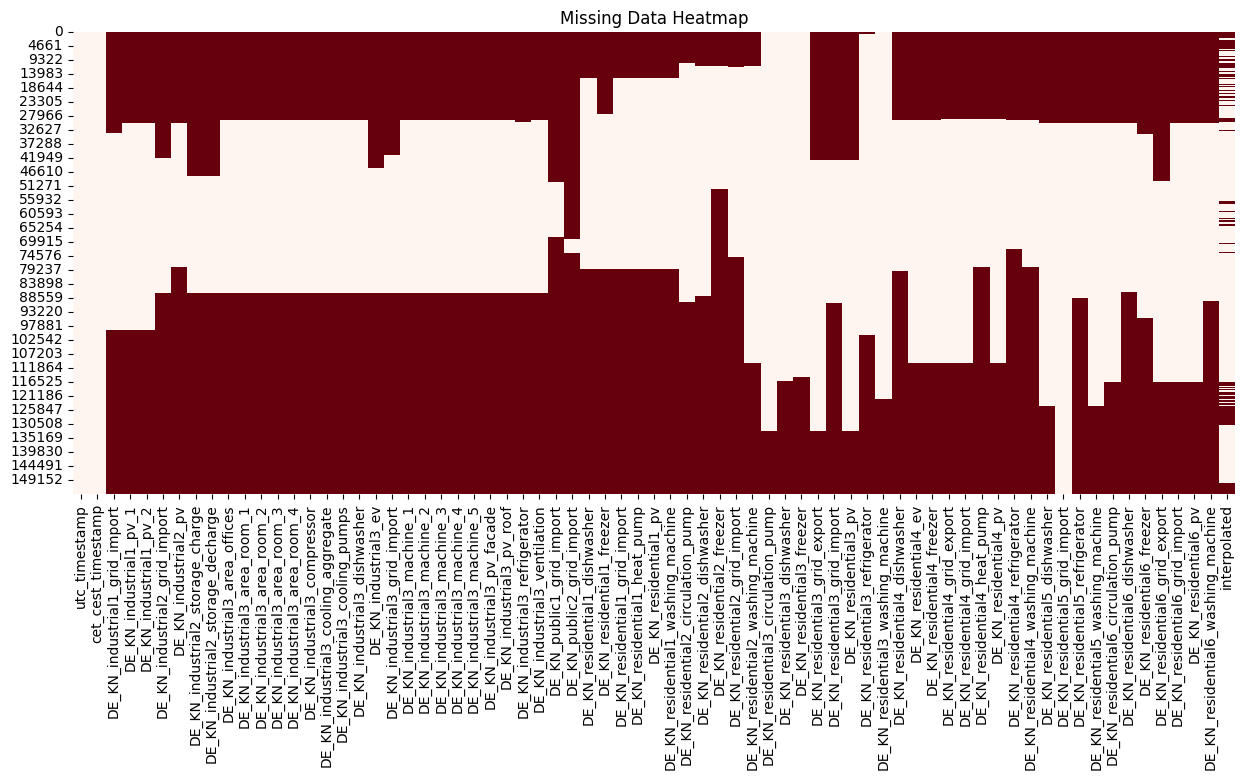

In [81]:
plt.figure(figsize=(15,6))
sns.heatmap(df.isnull(), cbar=False, cmap='Reds')
plt.title('Missing Data Heatmap')
plt.show()

In [20]:
# Assuming 'df' is your DataFrame

# 1. Calculating Descriptive Statistics for each numeric column
desc_stats = df.describe().transpose()

# Calculating Mode (as describe does not include it)
desc_stats['mode'] = df.mode().iloc[0]  # Taking the first mode value

# 2. Creating the summary DataFrame with additional statistics
desc_summary = desc_stats[['mean', '50%', 'mode', 'max', 'min']].rename(columns={
    'mean': 'Mean',
    '50%': 'Median',
    'mode': 'Mode',
    'max': 'Max',
    'min': 'Min'
})

# Reset the index and rename the index column
desc_summary = desc_summary.reset_index().rename(columns={'index': 'Column'})

# 3. Creating HTML table
desc_html = desc_summary.to_html(classes='styled-table', index=False)

# 4.Styling Css for the table (including color changes and centering the table)
css = """
<style>
.styled-table {
    border-collapse: collapse;
    font-size: 16px;
    font-family: 'Segoe UI', sans-serif;
    min-width: 600px;
    border-radius: 10px;
    overflow: hidden;
    box-shadow: 0 0 15px rgba(0, 0, 0, 0.1);
    background-color: #f2f2f2;
    margin: 20px auto;
}

.styled-table thead tr {
    background-color: #007BFF;
    color: #ffffff;
    text-align: left;
}

.styled-table th, .styled-table td {
    padding: 12px 15px;
}

.styled-table tbody tr {
    border-bottom: 1px solid #dddddd;
}

.styled-table tbody tr:nth-of-type(even) {
    background-color: #e6f7ff;
}

.styled-table tbody tr:hover {
    background-color: #d1e7ff;
}

.styled-table tbody tr:last-of-type {
    border-bottom: 2px solid #007BFF;
}

.table-container {
    display: flex;
    justify-content: center;
    align-items: center;
}
</style>
"""

# 5. Wrapping the table in a div container and display
html_output = f'<div class="table-container">{desc_html}</div>'
display(HTML(css + html_output))

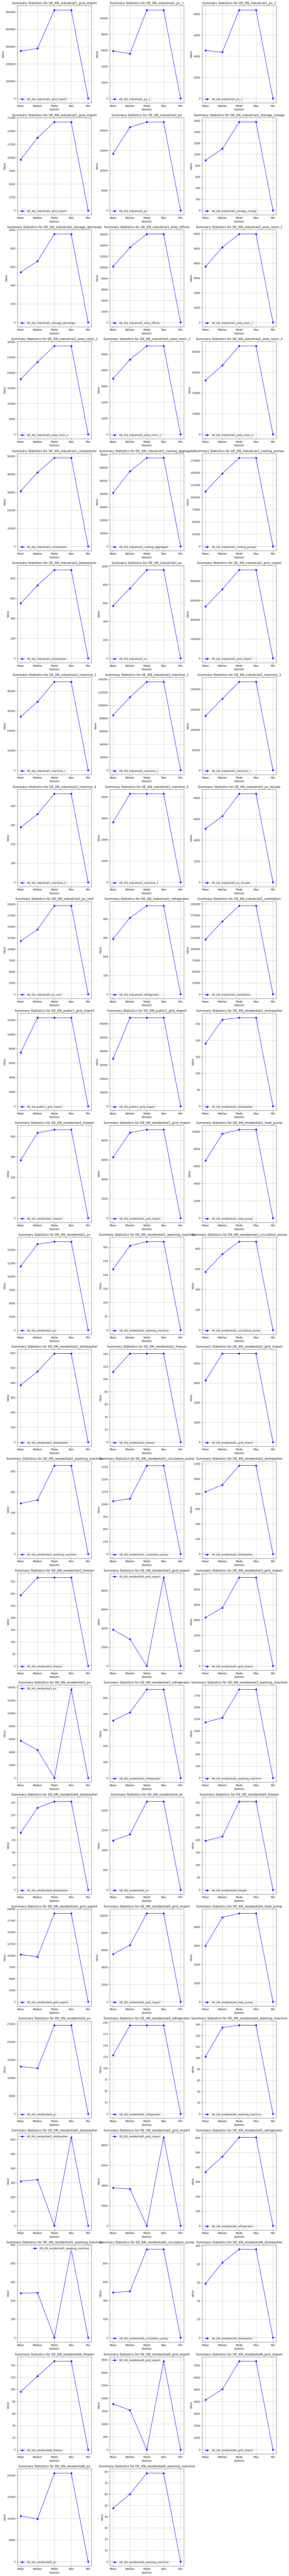

In [15]:
# Number of columns in the summary DataFrame
num_columns = len(desc_summary)
ncols = 3
nrows = (num_columns + ncols - 1) // ncols  # This calculates the number of rows needed

# Setting up the subplots grid
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 6 * nrows))

# Flatten axes array in case there are multiple rows and columns
axes = axes.flatten()

# Loop through each column in desc_summary and create a line plot
for i, (index, row) in enumerate(desc_summary.iterrows()):
    # Data to plot: Mean, Median, Mode, Max, Min
    statistics = ['Mean', 'Median', 'Mode', 'Max', 'Min']
    
    # Values for the current column
    values = [row['Mean'], row['Median'], row['Mode'], row['Max'], row['Min']]
    
    # Setting up the plot for the current column
    ax = axes[i]
    
    # Plotting the line
    ax.plot(statistics, values, marker='o', color='b', linestyle='-', label=row['Column'])
    
    # Setting up plot labels and title
    ax.set_xlabel('Statistic')
    ax.set_ylabel('Value')
    ax.set_title(f'Summary Statistics for {row["Column"]}')
    ax.grid(True)
    ax.legend()

# Turning off any unused axes (in case there are more subplots than columns)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjustting layout to prevent overlap
plt.tight_layout()
plt.show()

In [17]:
industry_cols = [col for col in df.columns if 'industrial' in col]
df_industry = df[['cet_cest_timestamp'] + industry_cols]
# Creating an HTML table using tabulate
industry_table = tabulate(df_industry.head(10), headers='keys', tablefmt='html', showindex=False)

styled_industry_table = f"""
<div style="font-family: Arial, sans-serif; background-color: #f9f9f9; padding: 20px; 
            border-radius: 10px; display: block; margin: 30px auto; overflow-x: auto;">

    <table style="border-collapse: collapse; margin: 0 auto; font-size: 16px; text-align: center; border: 1px solid #ddd;">
        <thead style="background-color: #4CAF50; color: white; font-weight: bold;">
            {industry_table.split('<thead>')[1].split('</thead>')[0]}
        </thead>
        <tbody>
            {industry_table.split('<tbody>')[1].split('</tbody>')[0]}
        </tbody>
    </table>
</div>
"""

# Displaying the styled table
display(HTML(styled_industry_table))

In [19]:
# Defining industry subsets
industry1_cols = [col for col in df.columns if 'industrial1' in col]
industry2_cols = [col for col in df.columns if 'industrial2' in col]
industry3_cols = [col for col in df.columns if 'industrial3' in col]

# Extracting data for each industry
df_industry1 = df[['cet_cest_timestamp'] + industry1_cols]
df_industry2 = df[['cet_cest_timestamp'] + industry2_cols]
df_industry3 = df[['cet_cest_timestamp'] + industry3_cols]

# Function to generate HTML table for each industry
def generate_industry_table(df_industry):
    # Creating an HTML table using tabulate
    industry_table = tabulate(df_industry.head(10), headers='keys', tablefmt='html', showindex=False)

    # Styling the table
    styled_industry_table = f"""
    <div style="font-family: Arial, sans-serif; background-color: #f9f9f9; padding: 20px; 
                border-radius: 10px; display: block; margin: 30px auto; overflow-x: auto;">
    
        <table style="border-collapse: collapse; margin: 0 auto; font-size: 16px; text-align: center; border: 1px solid #ddd;">
            <thead style="background-color: #4CAF50; color: white; font-weight: bold;">
                {industry_table.split('<thead>')[1].split('</thead>')[0]}
            </thead>
            <tbody>
                {industry_table.split('<tbody>')[1].split('</tbody>')[0]}
            </tbody>
        </table>
    </div>
    """
    return styled_industry_table

# Displaying the HTML table for each industry
industry1_table = generate_industry_table(df_industry1)
industry2_table = generate_industry_table(df_industry2)
industry3_table = generate_industry_table(df_industry3)

# Displaying tables for industry 1, 2, and 3
display(HTML(industry1_table))
display(HTML(industry2_table))
display(HTML(industry3_table))


In [21]:
df_residential4 = df[residential4_cols]

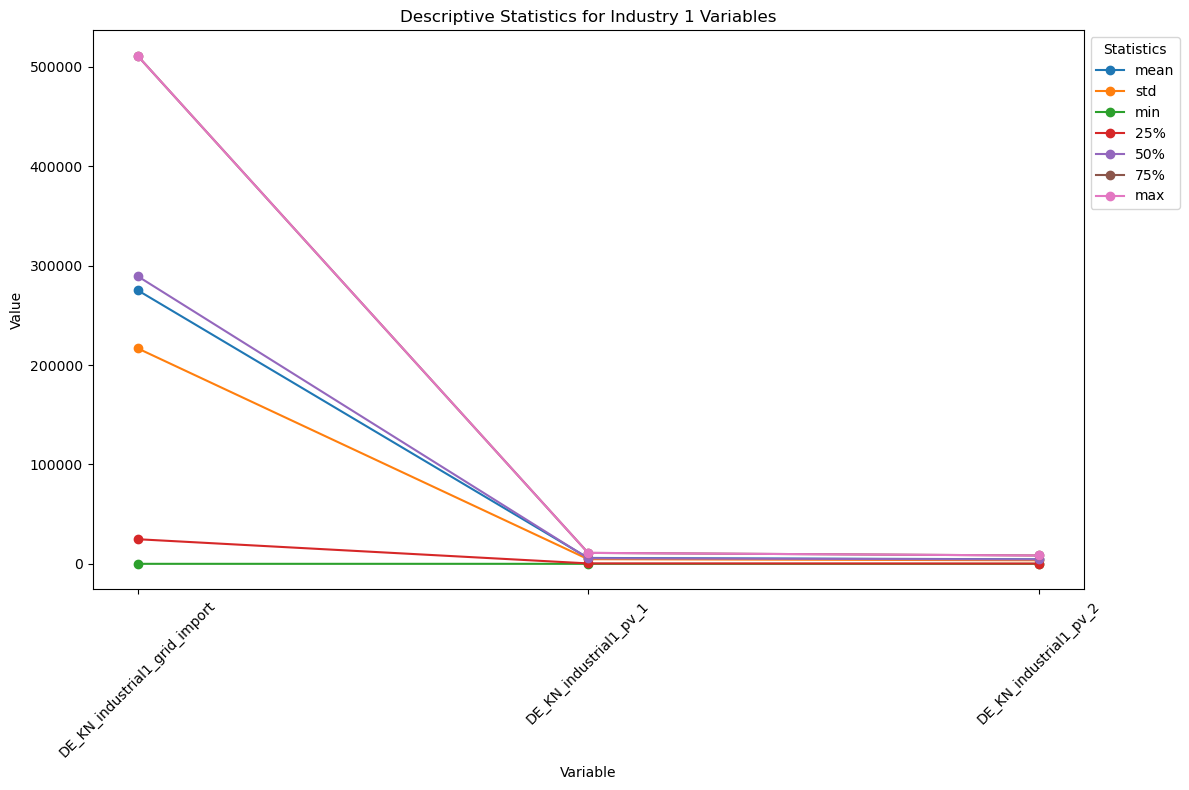

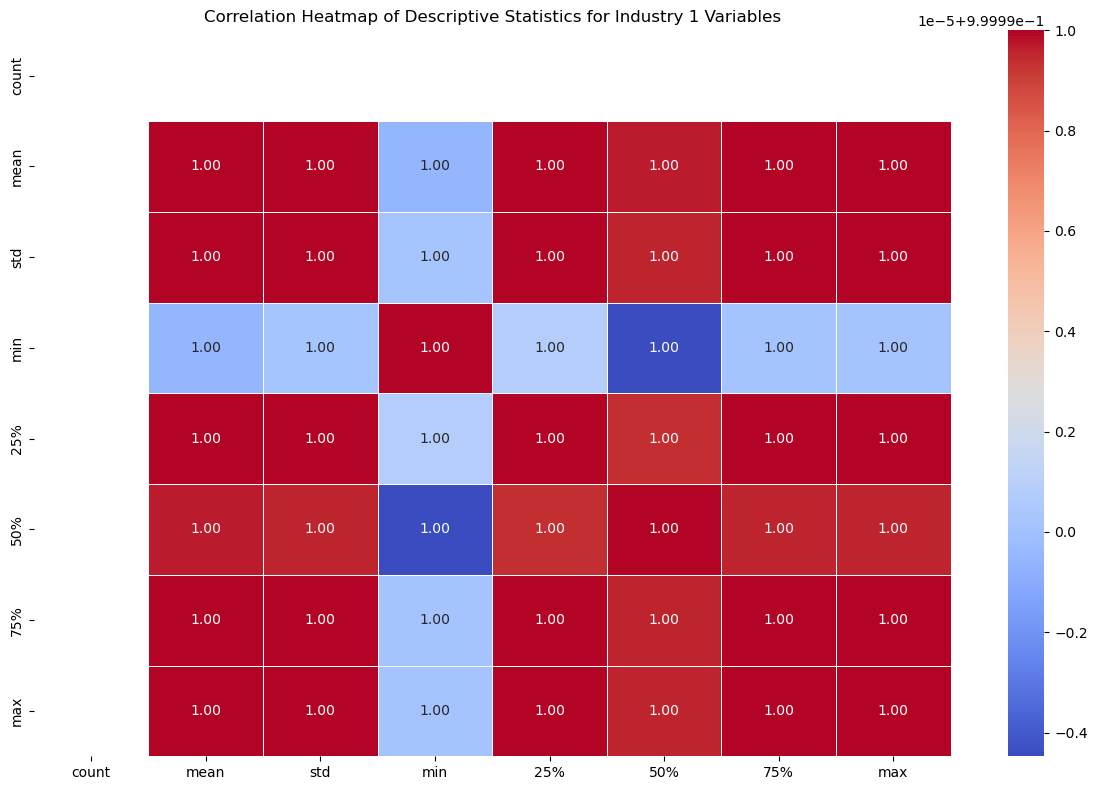

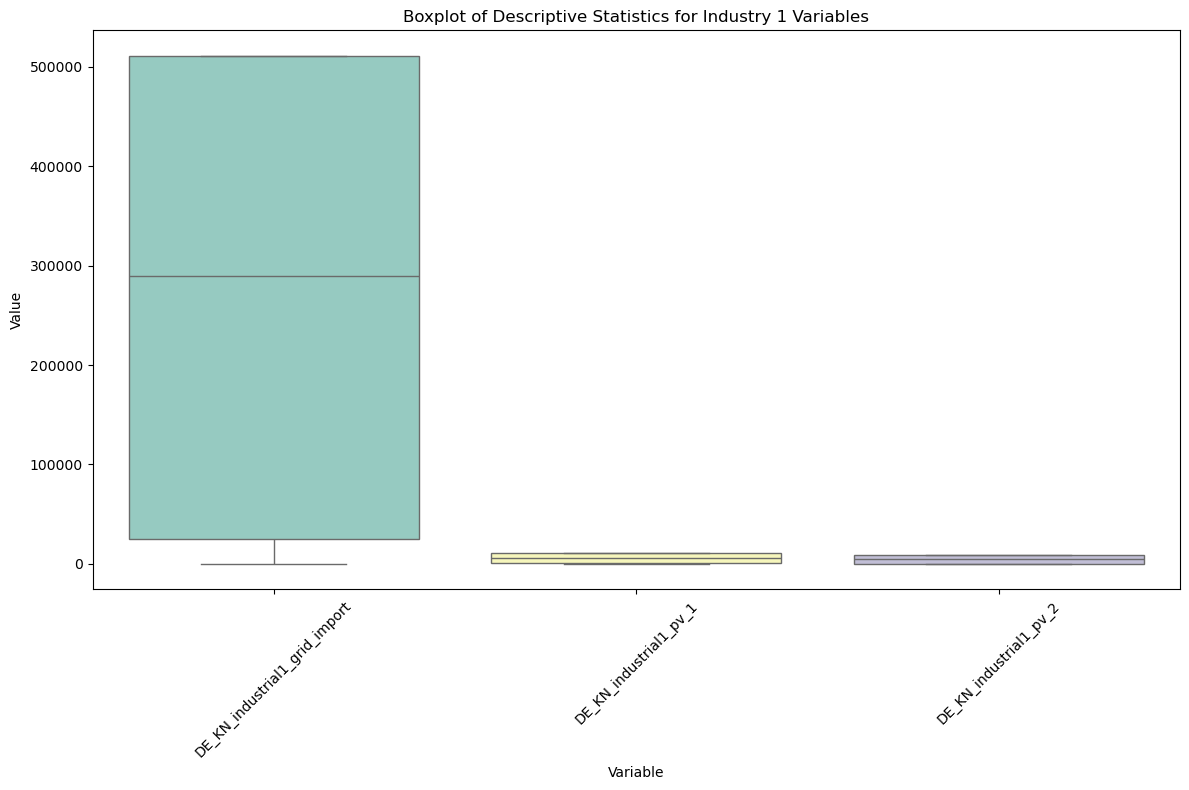

In [23]:
plt.figure(figsize=(12, 8))
statistics_to_plot = ['mean', 'std', 'min', '25%', '50%', '75%', 'max']

for stat in statistics_to_plot:
    plt.plot(industry1_descriptive_stats['Variable'], industry1_descriptive_stats[stat], label=stat, marker='o')

# Customizing the plot
plt.title('Descriptive Statistics for Industry 1 Variables')
plt.xlabel('Variable')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend(title='Statistics', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()



# Preparing the heatmap data (remove the 'Variable' column)
heatmap_data = industry1_descriptive_stats.drop(columns=['Variable'])

# Generating the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Customizing the plot
plt.title('Correlation Heatmap of Descriptive Statistics for Industry 1 Variables')
plt.tight_layout()
plt.show()



# Preparing the data for the boxplot by reformatting it
boxplot_data = industry1_descriptive_stats[['Variable', 'min', '25%', '50%', '75%', 'max']].set_index('Variable')

# Creating the boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(data=boxplot_data.T, palette='Set3')

# Customizing the plot
plt.title('Boxplot of Descriptive Statistics for Industry 1 Variables')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [25]:
# Generating descriptive statistics for Industry 2
industry2_descriptive_stats = df_industry2.describe().transpose()

# Resetting the index for better readability and display
industry2_descriptive_stats.reset_index(inplace=True)
industry2_descriptive_stats.rename(columns={'index': 'Variable'}, inplace=True)

# Converting the descriptive statistics to HTML format using tabulate
industry2_table_stats = tabulate(industry2_descriptive_stats, headers='keys', tablefmt='html', showindex=False)

# Styling the table
styled_industry2_stats_table = f"""
<div style="font-family: Arial, sans-serif; background-color: #f9f9f9; padding: 20px; 
            border-radius: 10px; display: block; margin: 30px auto; overflow-x: auto;">
    
    <table style="border-collapse: collapse; margin: 0 auto; font-size: 16px; text-align: center; border: 1px solid #ddd;">
        <thead style="background-color: #4CAF50; color: white; font-weight: bold;">
            {industry2_table_stats.split('<thead>')[1].split('</thead>')[0]}
        </thead>
        <tbody>
            {industry2_table_stats.split('<tbody>')[1].split('</tbody>')[0]}
        </tbody>
    </table>
</div>
"""

# Displaying the table with descriptive statistics for Industry 2
display(HTML(styled_industry2_stats_table))


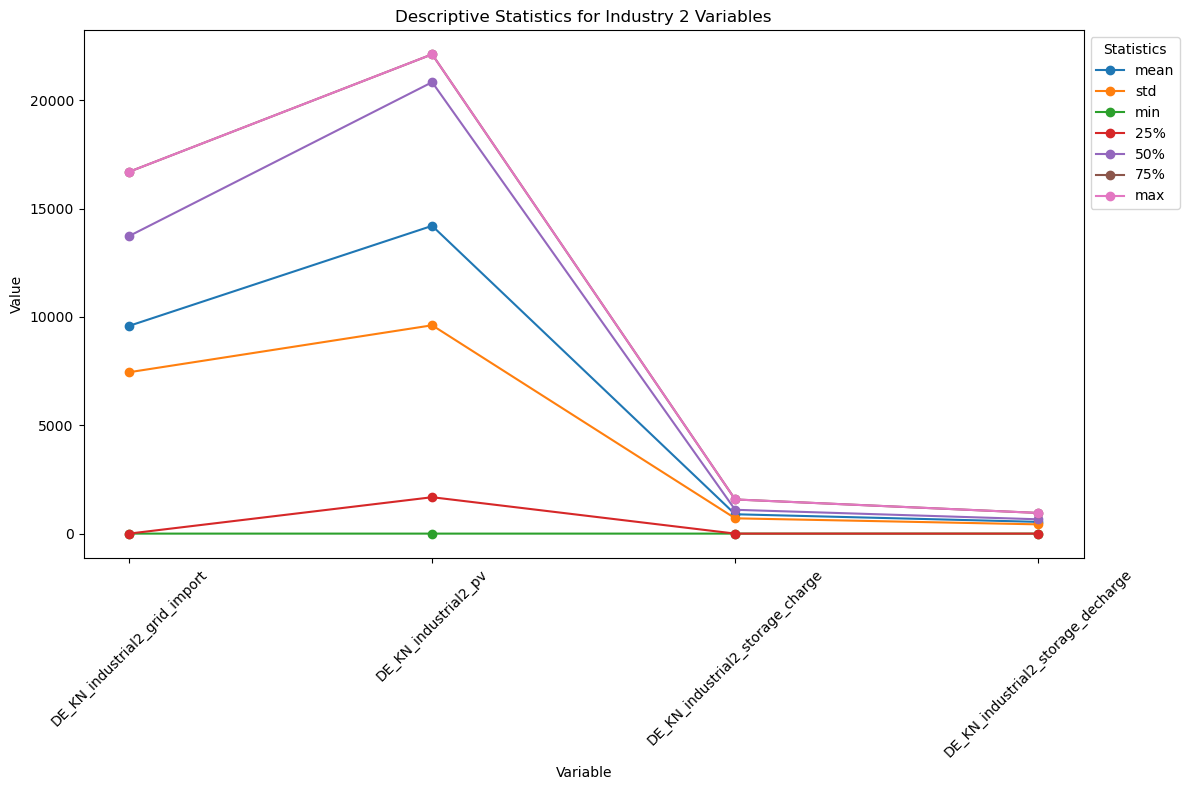

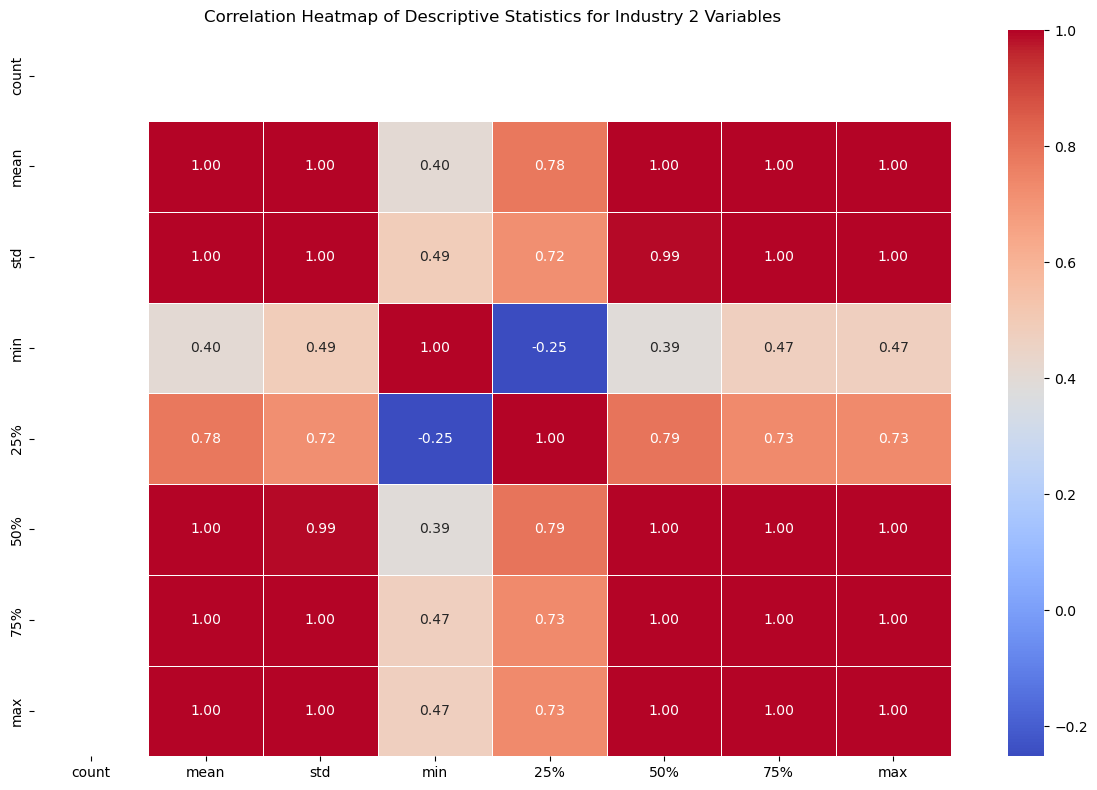

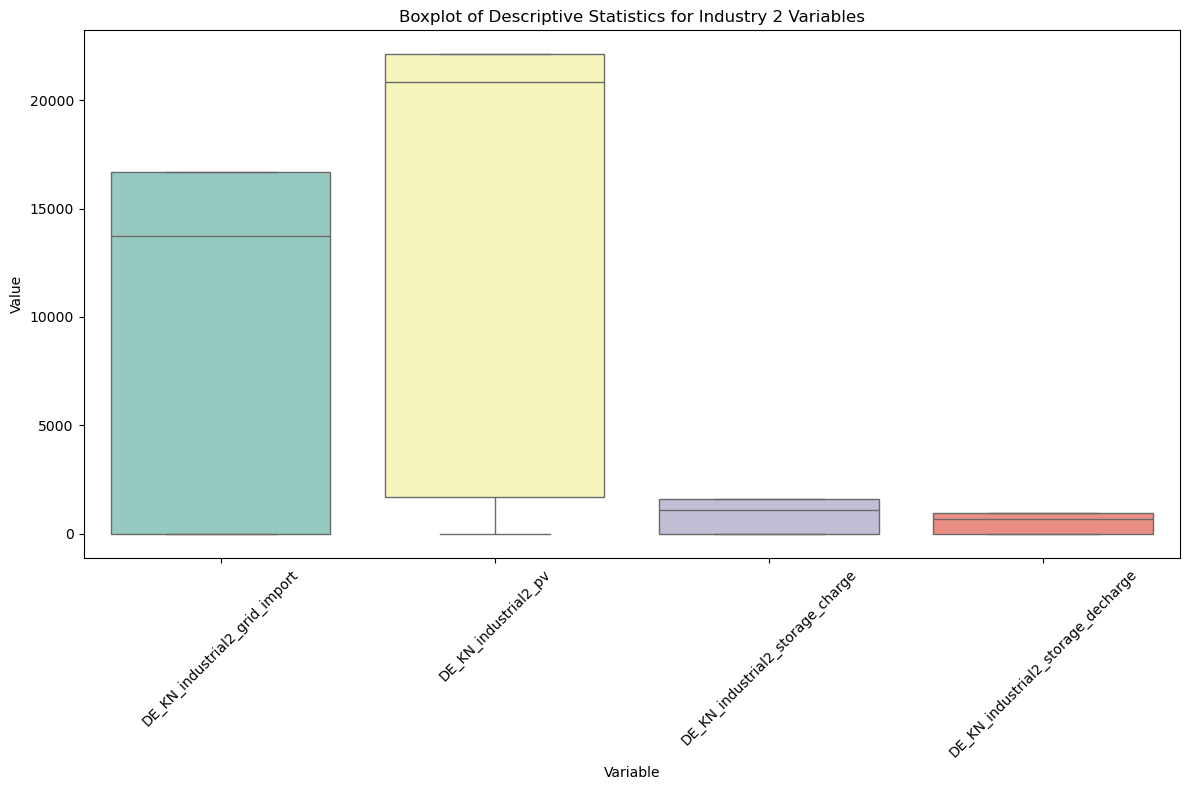

In [27]:
plt.figure(figsize=(12, 8))
statistics_to_plot = ['mean', 'std', 'min', '25%', '50%', '75%', 'max']

for stat in statistics_to_plot:
    plt.plot(industry2_descriptive_stats['Variable'], industry2_descriptive_stats[stat], label=stat, marker='o')

# Customizing the plot
plt.title('Descriptive Statistics for Industry 2 Variables')
plt.xlabel('Variable')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend(title='Statistics', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Plot 2: Correlation Heatmap of Descriptive Statistics
# Preparing the heatmap data (remove the 'Variable' column)
heatmap_data = industry2_descriptive_stats.drop(columns=['Variable'])

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Customizing the plot
plt.title('Correlation Heatmap of Descriptive Statistics for Industry 2 Variables')
plt.tight_layout()
plt.show()

# Plot 3: Boxplot for the descriptive statistics (min, 25%, 50%, 75%, max)
# Preparing the data for the boxplot by reformatting it
boxplot_data = industry2_descriptive_stats[['Variable', 'min', '25%', '50%', '75%', 'max']].set_index('Variable')

plt.figure(figsize=(12, 8))
sns.boxplot(data=boxplot_data.T, palette='Set3')

# Customizing the plot
plt.title('Boxplot of Descriptive Statistics for Industry 2 Variables')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [29]:
# Generating descriptive statistics for Industry 2
industry3_descriptive_stats = df_industry3.describe().transpose()

# Reseting the index for better readability and display
industry3_descriptive_stats.reset_index(inplace=True)
industry3_descriptive_stats.rename(columns={'index': 'Variable'}, inplace=True)

# Converting the descriptive statistics to HTML format using tabulate
industry3_table_stats = tabulate(industry3_descriptive_stats, headers='keys', tablefmt='html', showindex=False)

# Styling the table
styled_industry3_stats_table = f"""
<div style="font-family: Arial, sans-serif; background-color: #f9f9f9; padding: 20px; 
            border-radius: 10px; display: block; margin: 30px auto; overflow-x: auto;">
    
    <table style="border-collapse: collapse; margin: 0 auto; font-size: 16px; text-align: center; border: 1px solid #ddd;">
        <thead style="background-color: #4CAF50; color: white; font-weight: bold;">
            {industry3_table_stats.split('<thead>')[1].split('</thead>')[0]}
        </thead>
        <tbody>
            {industry3_table_stats.split('<tbody>')[1].split('</tbody>')[0]}
        </tbody>
    </table>
</div>
"""

# Displaying the table with descriptive statistics for Industry 2
display(HTML(styled_industry3_stats_table))


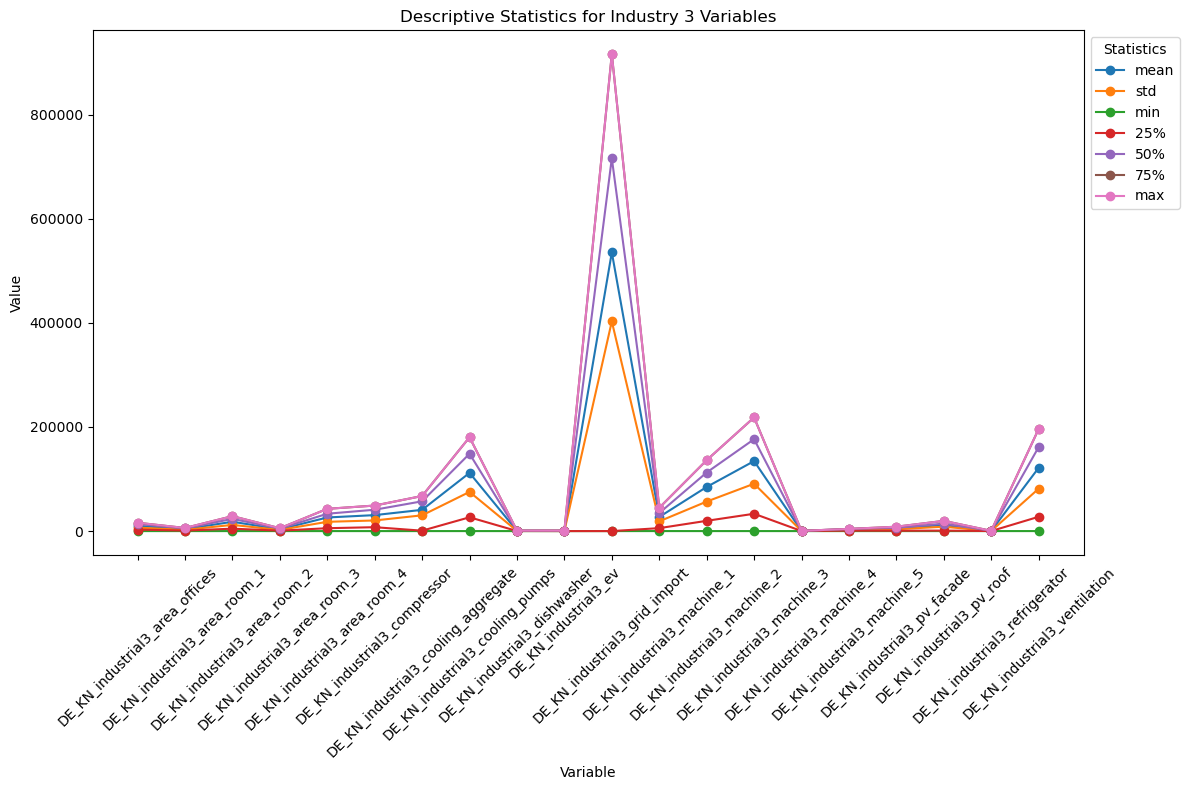

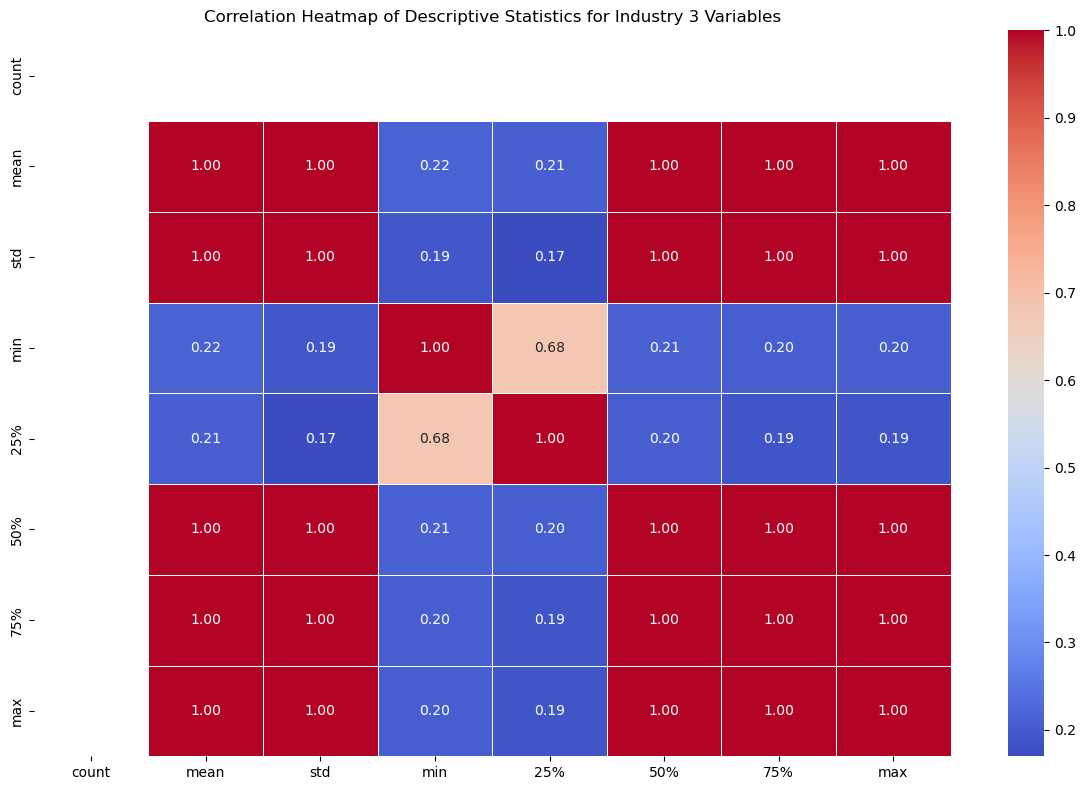

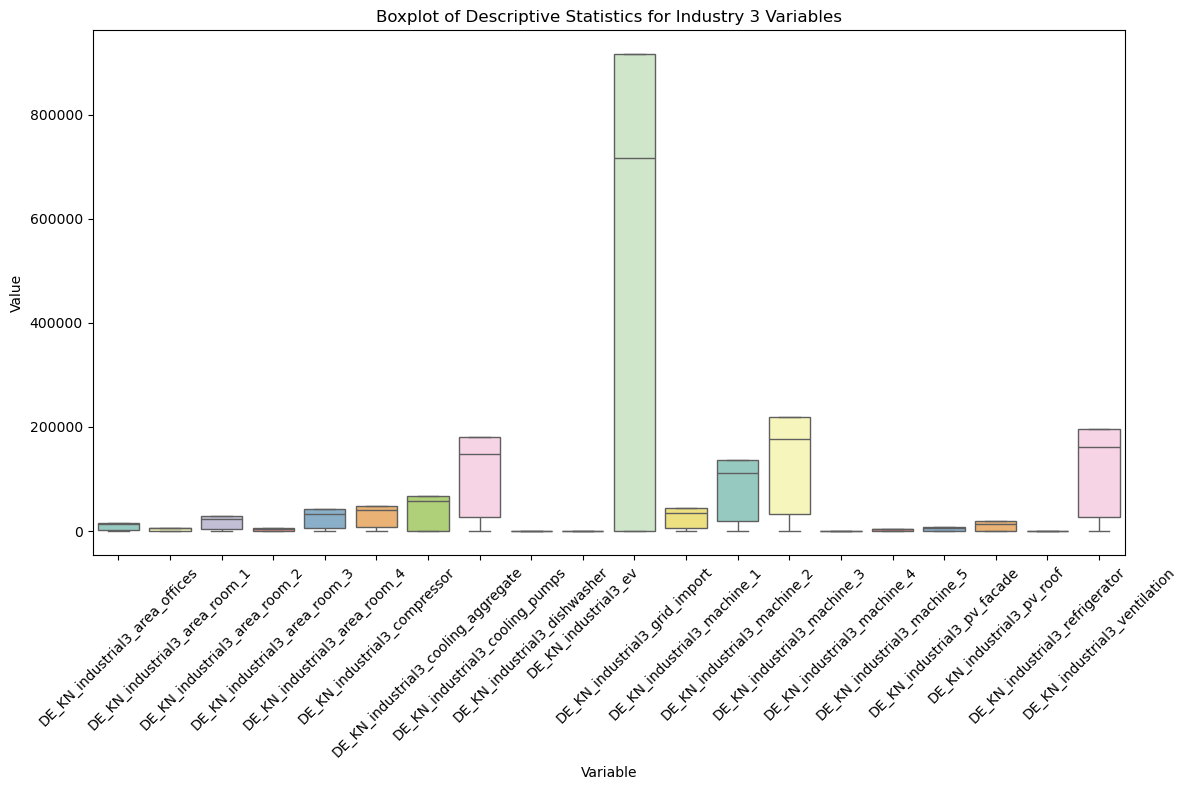

In [31]:
plt.figure(figsize=(12, 8))
statistics_to_plot = ['mean', 'std', 'min', '25%', '50%', '75%', 'max']

for stat in statistics_to_plot:
    plt.plot(industry3_descriptive_stats['Variable'], industry3_descriptive_stats[stat], label=stat, marker='o')

# Customizing the plot
plt.title('Descriptive Statistics for Industry 3 Variables')
plt.xlabel('Variable')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend(title='Statistics', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Plot 2: Correlation Heatmap of Descriptive Statistics
# Preparing the heatmap data (remove the 'Variable' column)
heatmap_data = industry3_descriptive_stats.drop(columns=['Variable'])

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Customizing the plot
plt.title('Correlation Heatmap of Descriptive Statistics for Industry 3 Variables')
plt.tight_layout()
plt.show()

# Plot 3: Boxplot for the descriptive statistics (min, 25%, 50%, 75%, max)
# Preparing the data for the boxplot by reformatting it
boxplot_data = industry3_descriptive_stats[['Variable', 'min', '25%', '50%', '75%', 'max']].set_index('Variable')

plt.figure(figsize=(12, 8))
sns.boxplot(data=boxplot_data.T, palette='Set3')

# Customizing the plot
plt.title('Boxplot of Descriptive Statistics for Industry 3 Variables')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [33]:
df['cet_cest_timestamp'] = pd.to_datetime(df['cet_cest_timestamp'], utc=True)

# Setting 'cet_cest_timestamp' as the index if it's not already the index
df.set_index('cet_cest_timestamp', inplace=True)

# Groupping columns for each industry (this part is already done)
industry1_cols = [col for col in df.columns if 'industrial1' in col]
industry2_cols = [col for col in df.columns if 'industrial2' in col]
industry3_cols = [col for col in df.columns if 'industrial3' in col]

# Resampling by week for each industry
# Industry 1
df_industry1_weekly = df[industry1_cols].resample('W').mean()

# Industry 2
df_industry2_weekly = df[industry2_cols].resample('W').mean()

# Industry 3
df_industry3_weekly = df[industry3_cols].resample('W').mean()

# Now creating HTML tables for each of the industry data
industry1_table = tabulate(df_industry1_weekly.head(10), headers='keys', tablefmt='html', showindex=True)
industry2_table = tabulate(df_industry2_weekly.head(10), headers='keys', tablefmt='html', showindex=True)
industry3_table = tabulate(df_industry3_weekly.head(10), headers='keys', tablefmt='html', showindex=True)

# Styling the tables
styled_industry1_table = f"""
<div style="font-family: Arial, sans-serif; background-color: #f9f9f9; padding: 20px; 
            border-radius: 10px; display: block; margin: 30px auto; overflow-x: auto;">

    <h3>Industry 1 Weekly Analysis</h3>
    <table style="border-collapse: collapse; margin: 0 auto; font-size: 16px; text-align: center; border: 1px solid #ddd;">
        <thead style="background-color: #4CAF50; color: white; font-weight: bold;">
            {industry1_table.split('<thead>')[1].split('</thead>')[0]}
        </thead>
        <tbody>
            {industry1_table.split('<tbody>')[1].split('</tbody>')[0]}
        </tbody>
    </table>
</div>
"""

styled_industry2_table = f"""
<div style="font-family: Arial, sans-serif; background-color: #f9f9f9; padding: 20px; 
            border-radius: 10px; display: block; margin: 30px auto; overflow-x: auto;">

    <h3>Industry 2 Weekly Analysis</h3>
    <table style="border-collapse: collapse; margin: 0 auto; font-size: 16px; text-align: center; border: 1px solid #ddd;">
        <thead style="background-color: #4CAF50; color: white; font-weight: bold;">
            {industry2_table.split('<thead>')[1].split('</thead>')[0]}
        </thead>
        <tbody>
            {industry2_table.split('<tbody>')[1].split('</tbody>')[0]}
        </tbody>
    </table>
</div>
"""

styled_industry3_table = f"""
<div style="font-family: Arial, sans-serif; background-color: #f9f9f9; padding: 20px; 
            border-radius: 10px; display: block; margin: 30px auto; overflow-x: auto;">

    <h3>Industry 3 Weekly Analysis</h3>
    <table style="border-collapse: collapse; margin: 0 auto; font-size: 16px; text-align: center; border: 1px solid #ddd;">
        <thead style="background-color: #4CAF50; color: white; font-weight: bold;">
            {industry3_table.split('<thead>')[1].split('</thead>')[0]}
        </thead>
        <tbody>
            {industry3_table.split('<tbody>')[1].split('</tbody>')[0]}
        </tbody>
    </table>
</div>
"""

# Displaying the styled tables
display(HTML(styled_industry1_table))
display(HTML(styled_industry2_table))
display(HTML(styled_industry3_table))

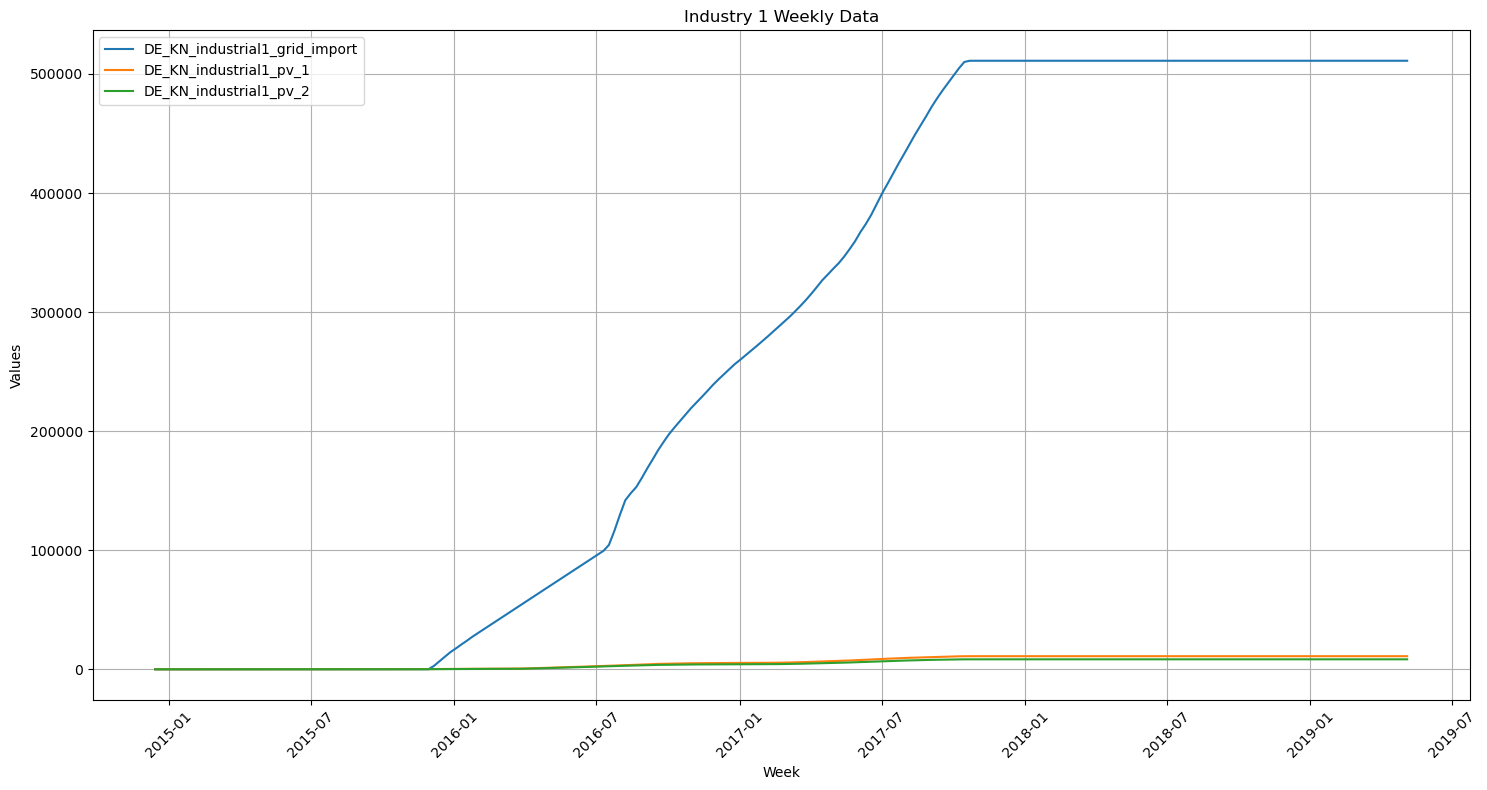

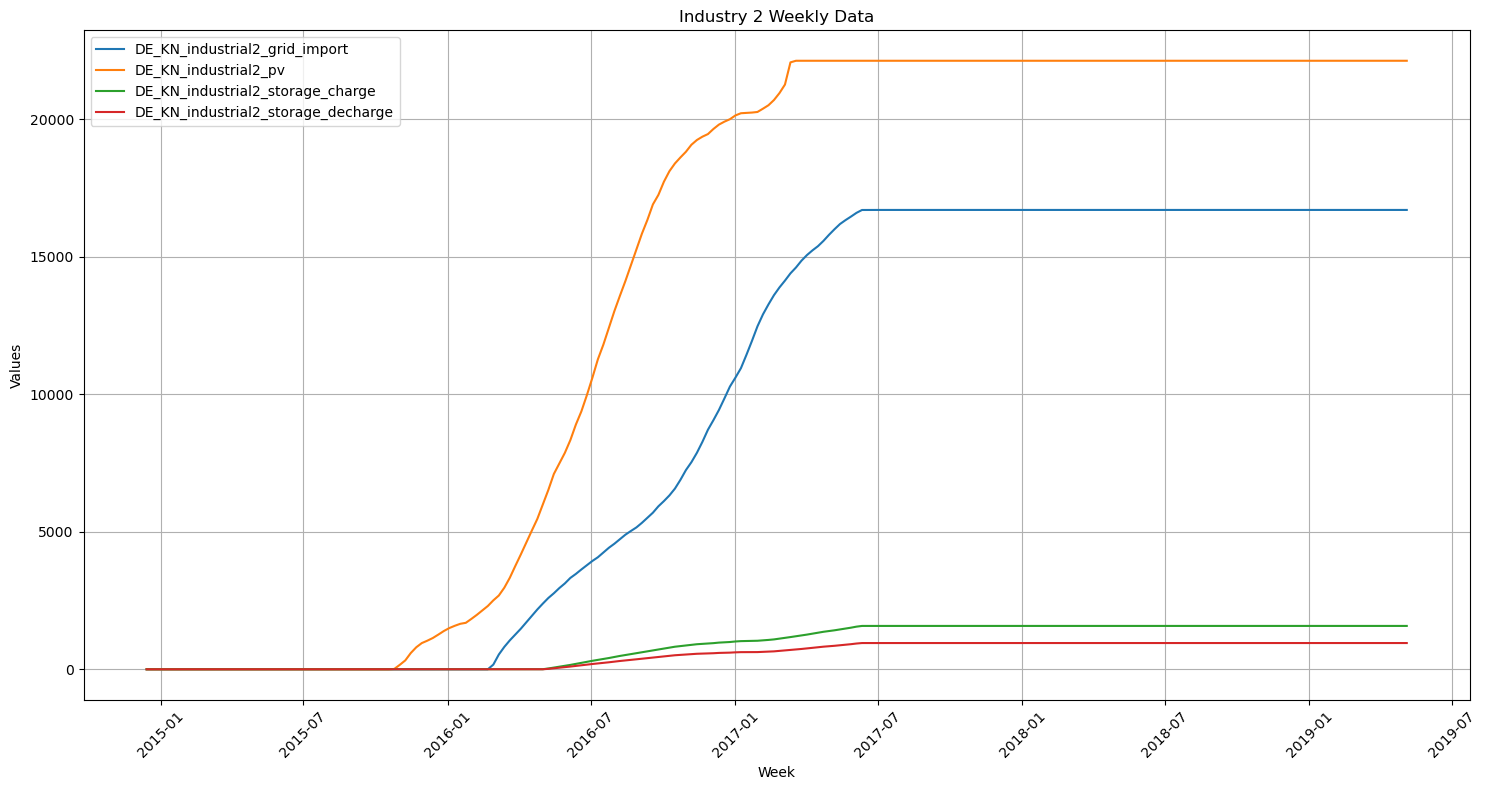

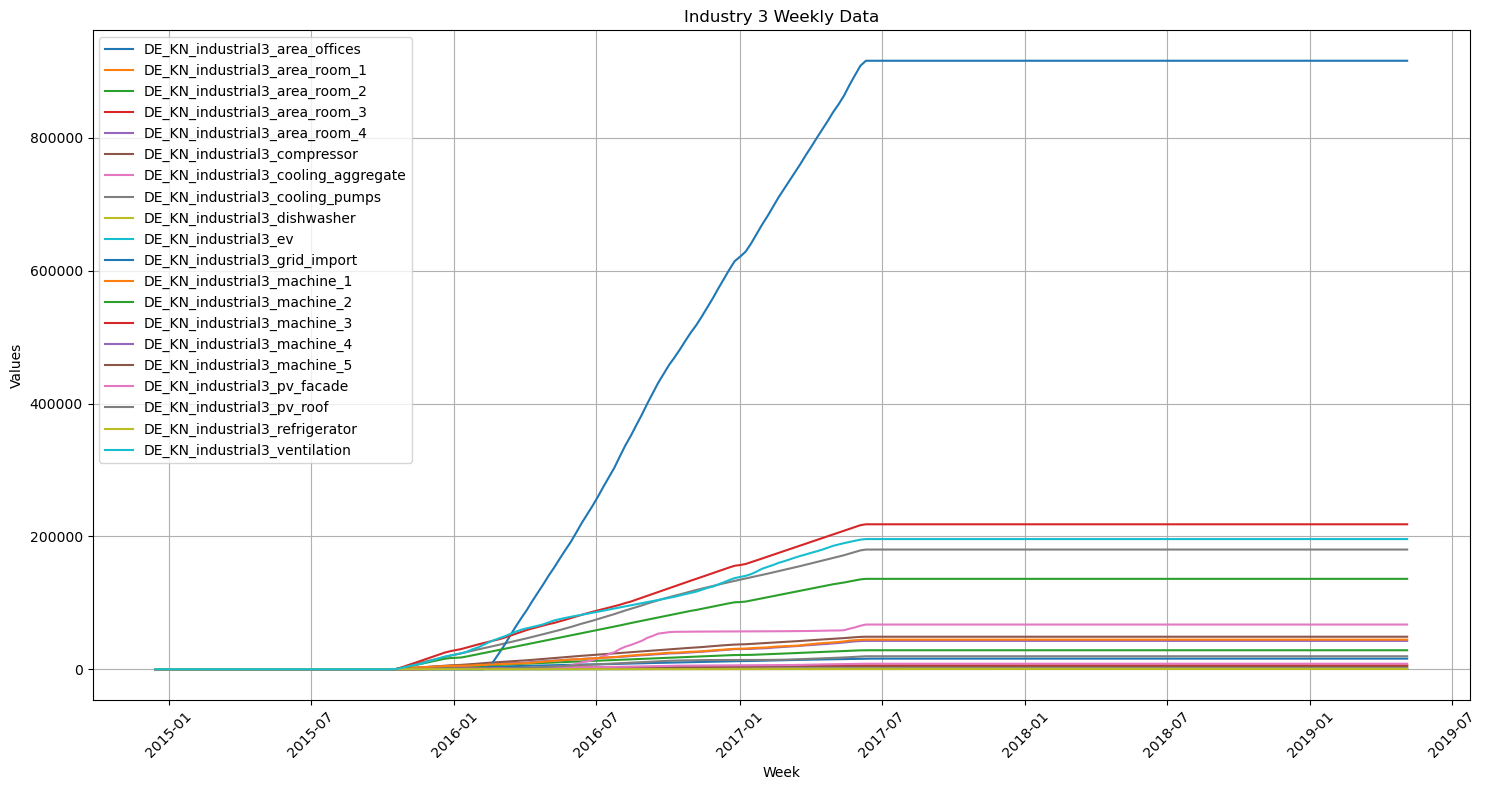

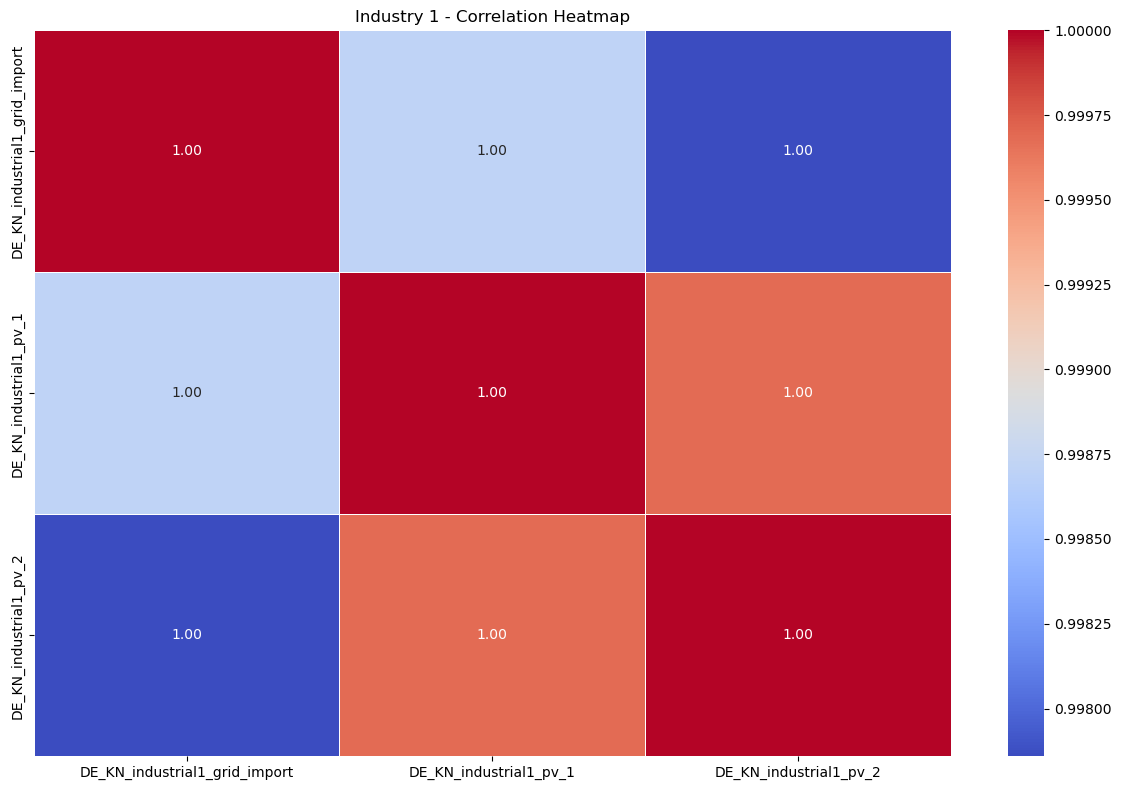

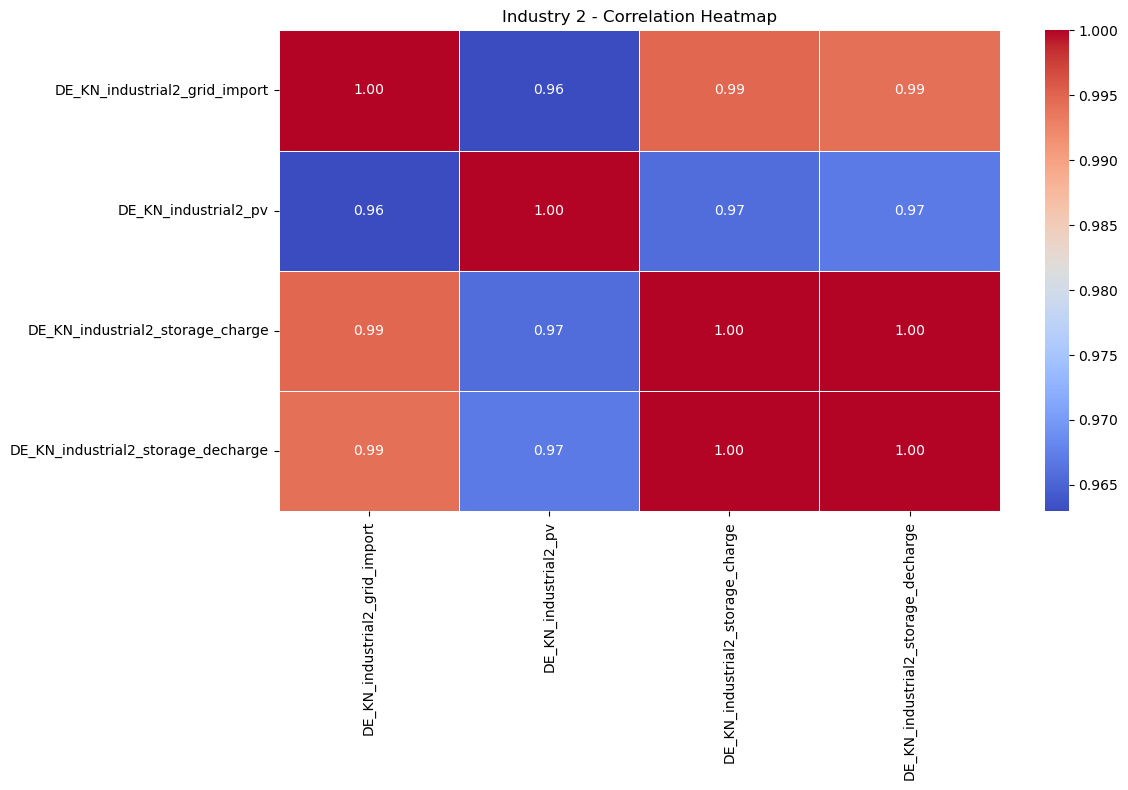

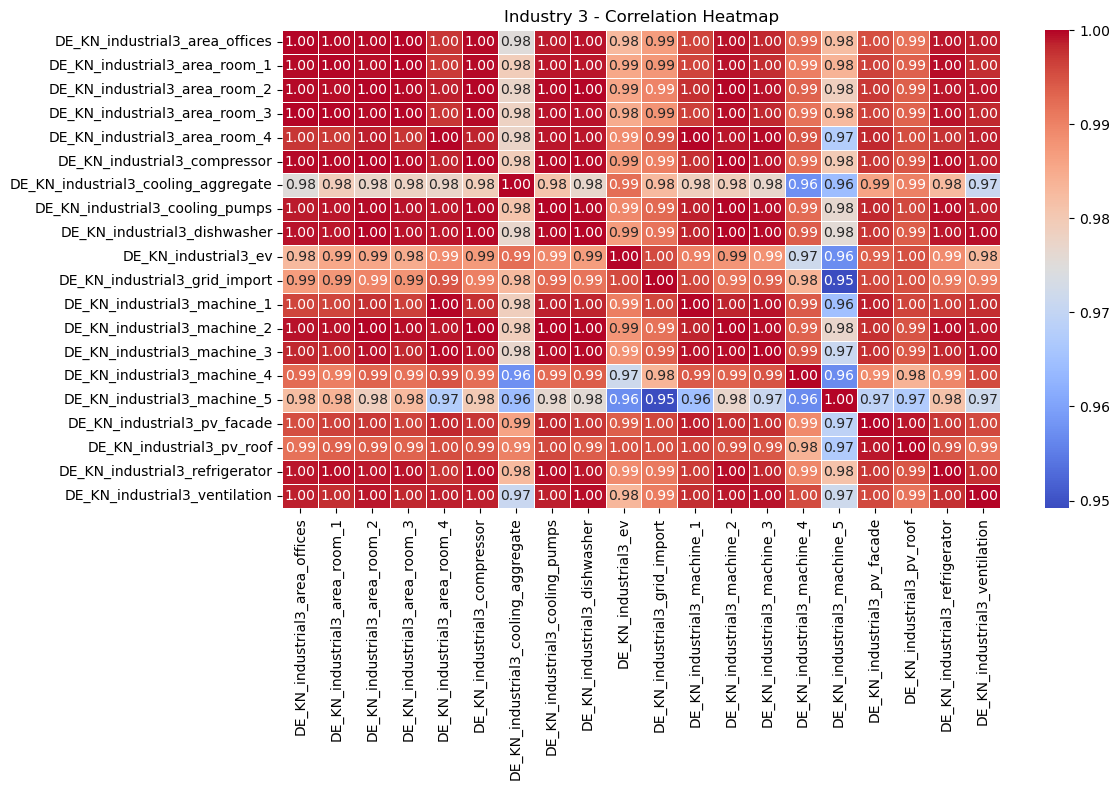

In [41]:

# Creating a function to plot each industry's data
def plot_industry_data(df_industry, industry_name):
    # Create a plot for each industry
    plt.figure(figsize=(15, 8))
    
    # Loop through the columns of the industry data and plot each column
    for column in df_industry.columns:
        plt.plot(df_industry.index, df_industry[column], label=column)

    # Title and labels
    plt.title(f'{industry_name} Weekly Data')
    plt.xlabel('Week')
    plt.ylabel('Values')
    plt.legend(loc='best')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot Industry 1
plot_industry_data(df_industry1_weekly, 'Industry 1')

# Plot Industry 2
plot_industry_data(df_industry2_weekly, 'Industry 2')

# Plot Industry 3
plot_industry_data(df_industry3_weekly, 'Industry 3') 


# Function to plot heatmap of correlations between columns in an industry
def plot_industry_heatmap(df_industry, industry_name):
    plt.figure(figsize=(12, 8))
    correlation_matrix = df_industry.corr()
    
    # Creating the heatmap
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    
    # Title and labels
    plt.title(f'{industry_name} - Correlation Heatmap')
    plt.tight_layout()
    plt.show()

# Plotting heatmap for Industry 1
plot_industry_heatmap(df_industry1_weekly, 'Industry 1')

# Plotting heatmap for Industry 2
plot_industry_heatmap(df_industry2_weekly, 'Industry 2')

# Plotting heatmap for Industry 3
plot_industry_heatmap(df_industry3_weekly, 'Industry 3')

In [58]:
df_reset = df.reset_index()
df_residential = df_reset[['cet_cest_timestamp'] + residential_cols]

# Creating an HTML table using tabulate
residential_table = tabulate(df_residential.head(10), headers='keys', tablefmt='html', showindex=False)

styled_residential_table = f"""
<div style="font-family: Arial, sans-serif; background-color: #f9f9f9; padding: 20px; 
            border-radius: 10px; display: block; margin: 30px auto; overflow-x: auto;">

    <table style="border-collapse: collapse; margin: 0 auto; font-size: 16px; text-align: center; border: 1px solid #ddd;">
        <thead style="background-color: #4CAF50; color: white; font-weight: bold;">
            {residential_table.split('<thead>')[1].split('</thead>')[0]}
        </thead>
        <tbody>
            {residential_table.split('<tbody>')[1].split('</tbody>')[0]}
        </tbody>
    </table>
</div>
"""

# Displaying the styled table
display(HTML(styled_residential_table))

In [94]:
# Defining industry subsets
residential1_cols = [col for col in df.columns if 'residential1' in col]
residential2_cols = [col for col in df.columns if 'residential2' in col]
residential3_cols = [col for col in df.columns if 'residential3' in col]
residential4_cols = [col for col in df.columns if 'residential4' in col]
residential5_cols = [col for col in df.columns if 'residential5' in col]
residential6_cols = [col for col in df.columns if 'residential6' in col]

# Extracting data for each industry
df_residential1 = df[residential1_cols]
df_residential2 = df[residential2_cols]
df_residential3 = df[residential3_cols]
df_residential4 = df[residential4_cols]
df_residential5 = df[residential5_cols]
df_residential6 = df[residential6_cols]

# Function to generate HTML table for each industry
def generate_residential_table(df_residential):
    # Creating an HTML table using tabulate
    residential_table = tabulate(df_residential.head(10), headers='keys', tablefmt='html', showindex=False)

    # Styaling the table
    styled_residential_table = f"""
    <div style="font-family: Arial, sans-serif; background-color: #f9f9f9; padding: 20px; 
                border-radius: 10px; display: block; margin: 30px auto; overflow-x: auto;">
    
        <table style="border-collapse: collapse; margin: 0 auto; font-size: 16px; text-align: center; border: 1px solid #ddd;">
            <thead style="background-color: #4CAF50; color: white; font-weight: bold;">
                {residential_table.split('<thead>')[1].split('</thead>')[0]}
            </thead>
            <tbody>
                {residential_table.split('<tbody>')[1].split('</tbody>')[0]}
            </tbody>
        </table>
    </div>
    """
    return styled_residential_table

# Displaying the HTML table for each industry
residential1_table = generate_residential_table(df_residential1)
residential2_table = generate_residential_table(df_residential2)
residential3_table = generate_residential_table(df_residential3)
residential4_table = generate_residential_table(df_residential4)
residential5_table = generate_residential_table(df_residential5)
residential6_table = generate_residential_table(df_residential6)

# Displaying tables for industry 1, 2, and 3
display(HTML(residential1_table))
display(HTML(residential2_table))
display(HTML(residential3_table))
display(HTML(residential4_table))
display(HTML(residential5_table))
display(HTML(residential6_table))


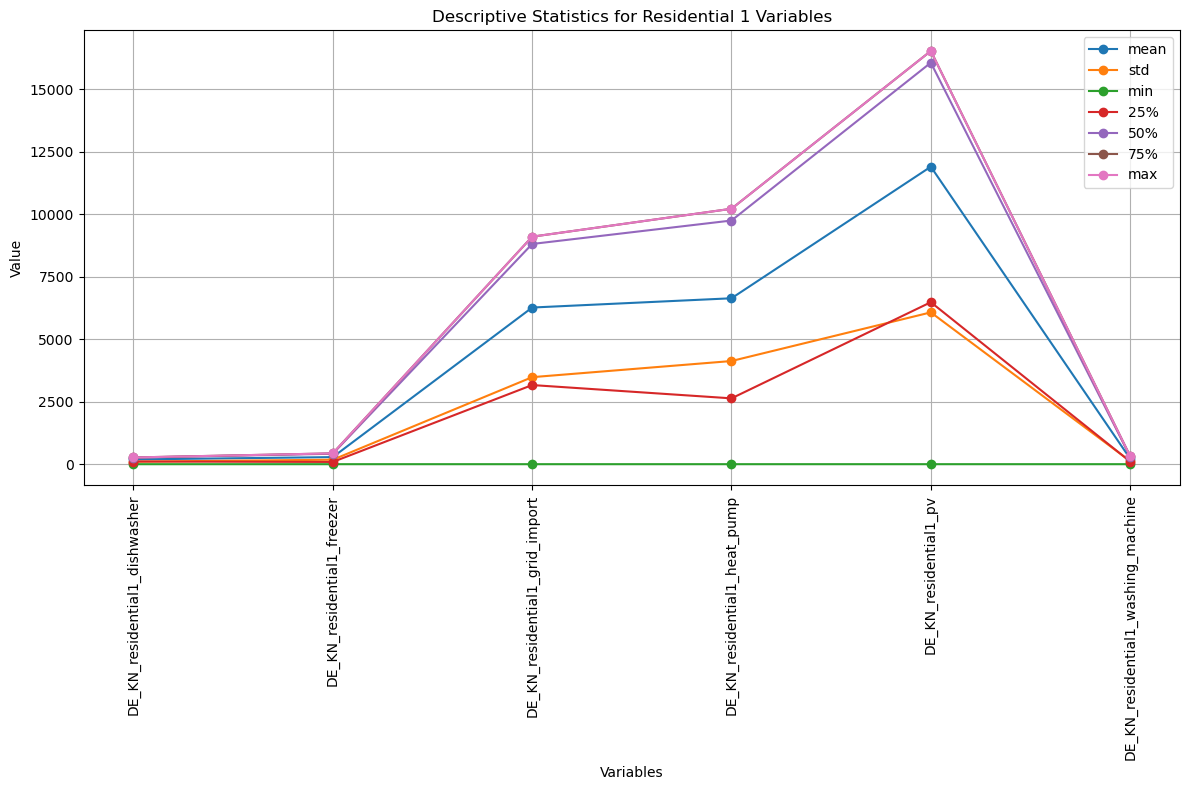

In [76]:
# Assuming df_residential1 is your DataFrame with numeric columns
residential1_descriptive_stats = df_residential1.describe().transpose().reset_index()
residential1_descriptive_stats.rename(columns={'index': 'Variable'}, inplace=True)

plt.figure(figsize=(12, 8))
statistics_to_plot = ['mean', 'std', 'min', '25%', '50%', '75%', 'max']

for stat in statistics_to_plot:
    plt.plot(residential1_descriptive_stats['Variable'], residential1_descriptive_stats[stat], label=stat, marker='o')

plt.title('Descriptive Statistics for Residential 1 Variables')
plt.xlabel('Variables')
plt.ylabel('Value')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


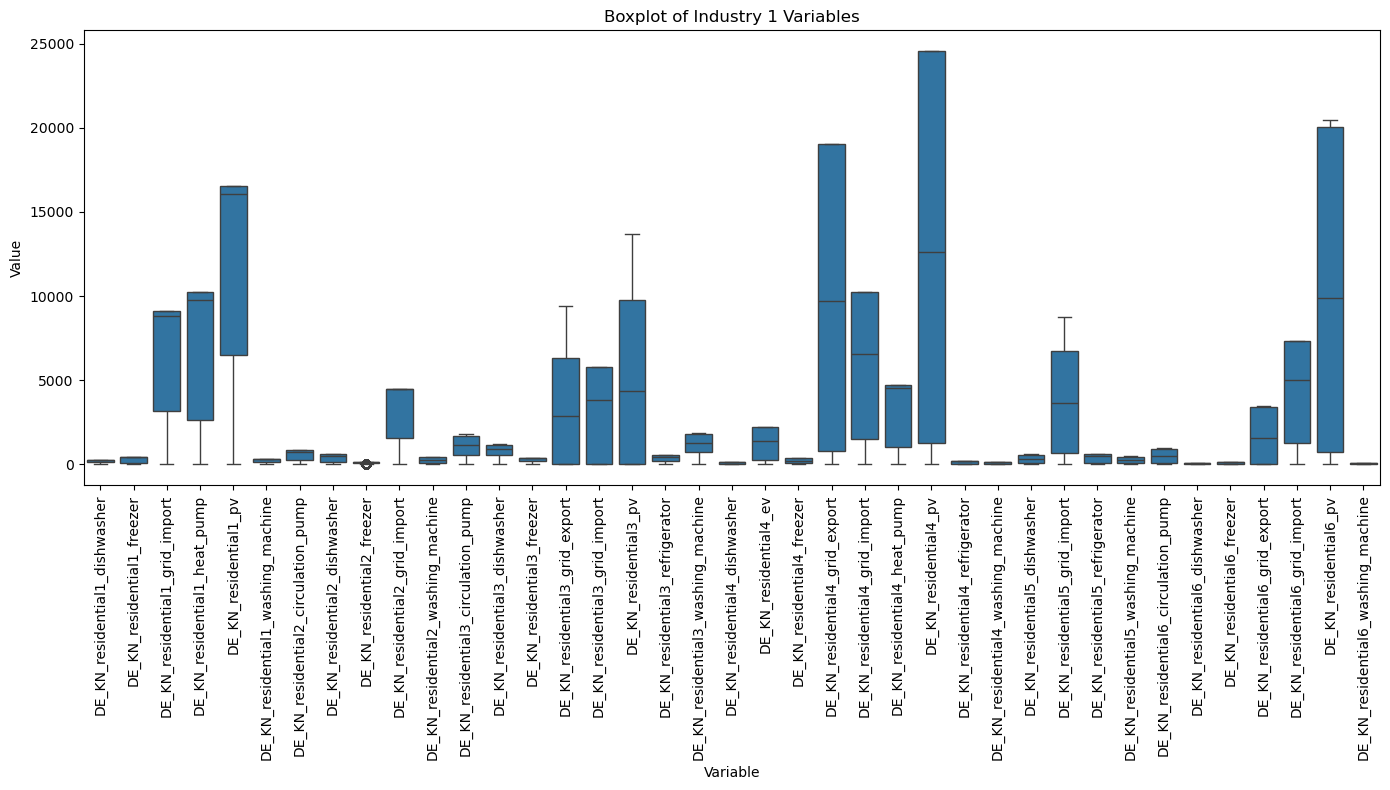

In [92]:
# Melt without the timestamp
df_melted = df_residential.drop(columns=['cet_cest_timestamp']).melt(var_name='Variable', value_name='Value')

plt.figure(figsize=(14, 8))
sns.boxplot(x='Variable', y='Value', data=df_melted)
plt.title('Boxplot of Industry 1 Variables')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()




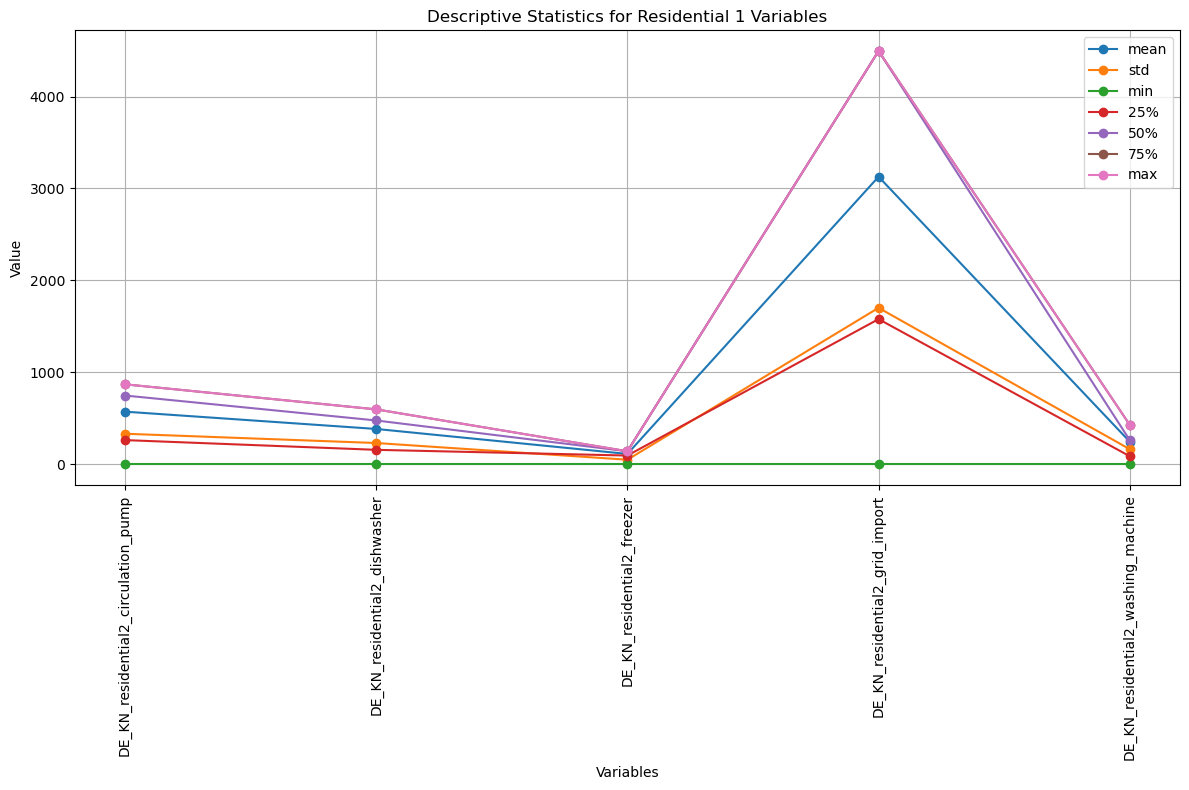

In [86]:
# Assuming df_residential1 is your DataFrame with numeric columns
residential2_descriptive_stats = df_residential2.describe().transpose().reset_index()
residential2_descriptive_stats.rename(columns={'index': 'Variable'}, inplace=True)

plt.figure(figsize=(12, 8))
statistics_to_plot = ['mean', 'std', 'min', '25%', '50%', '75%', 'max']

for stat in statistics_to_plot:
    plt.plot(residential2_descriptive_stats['Variable'], residential2_descriptive_stats[stat], label=stat, marker='o')

plt.title('Descriptive Statistics for Residential 1 Variables')
plt.xlabel('Variables')
plt.ylabel('Value')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

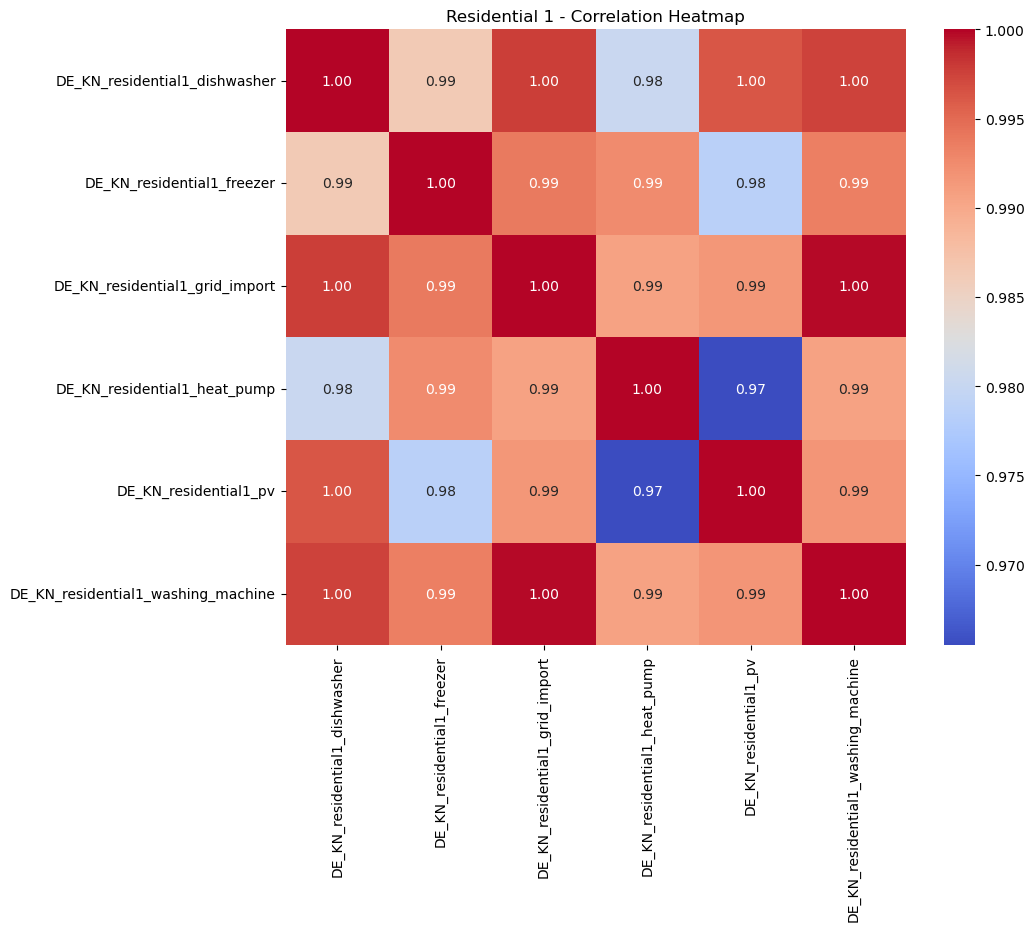

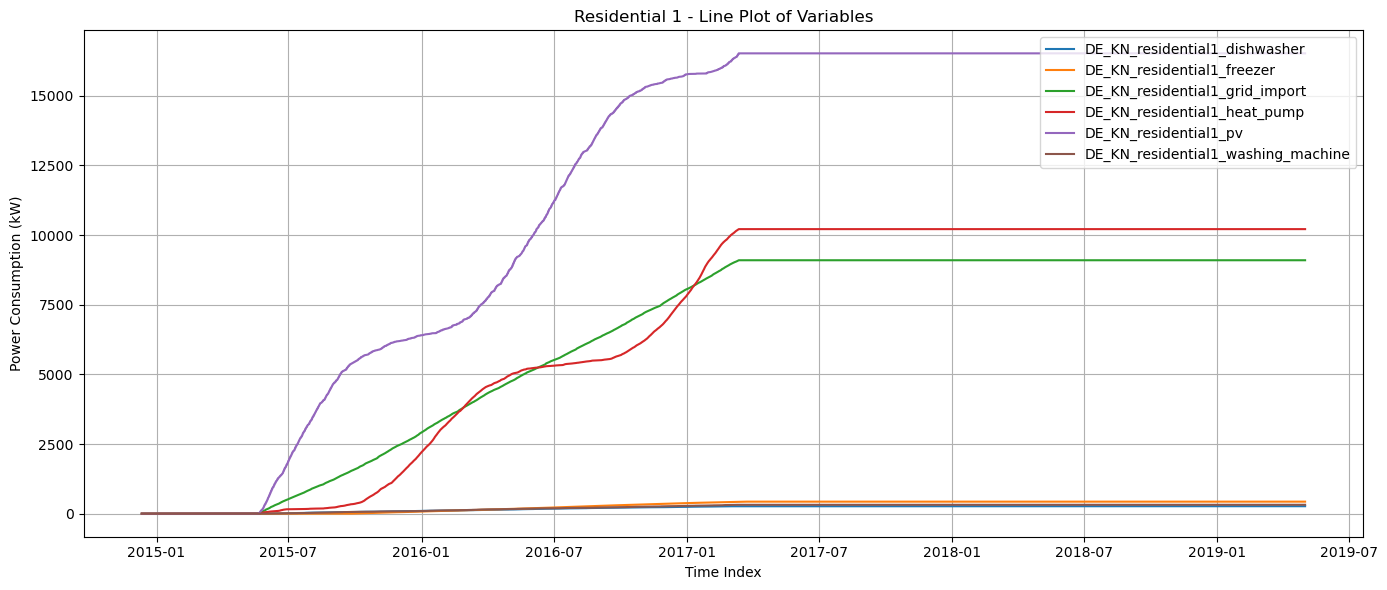

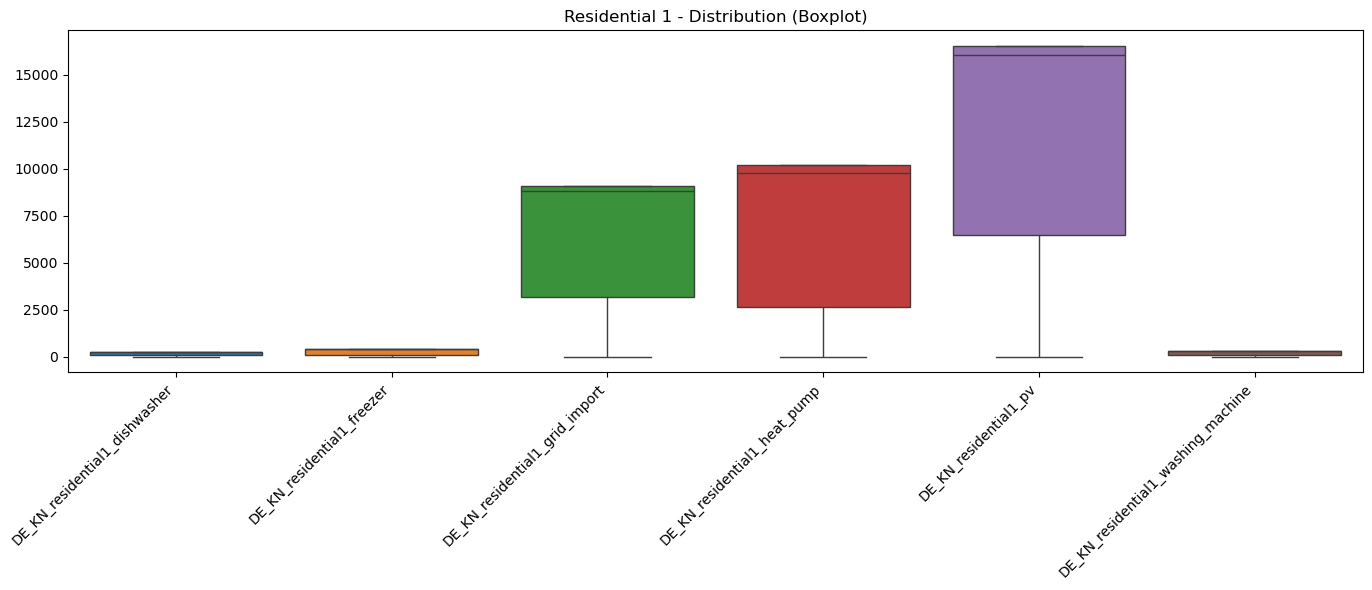

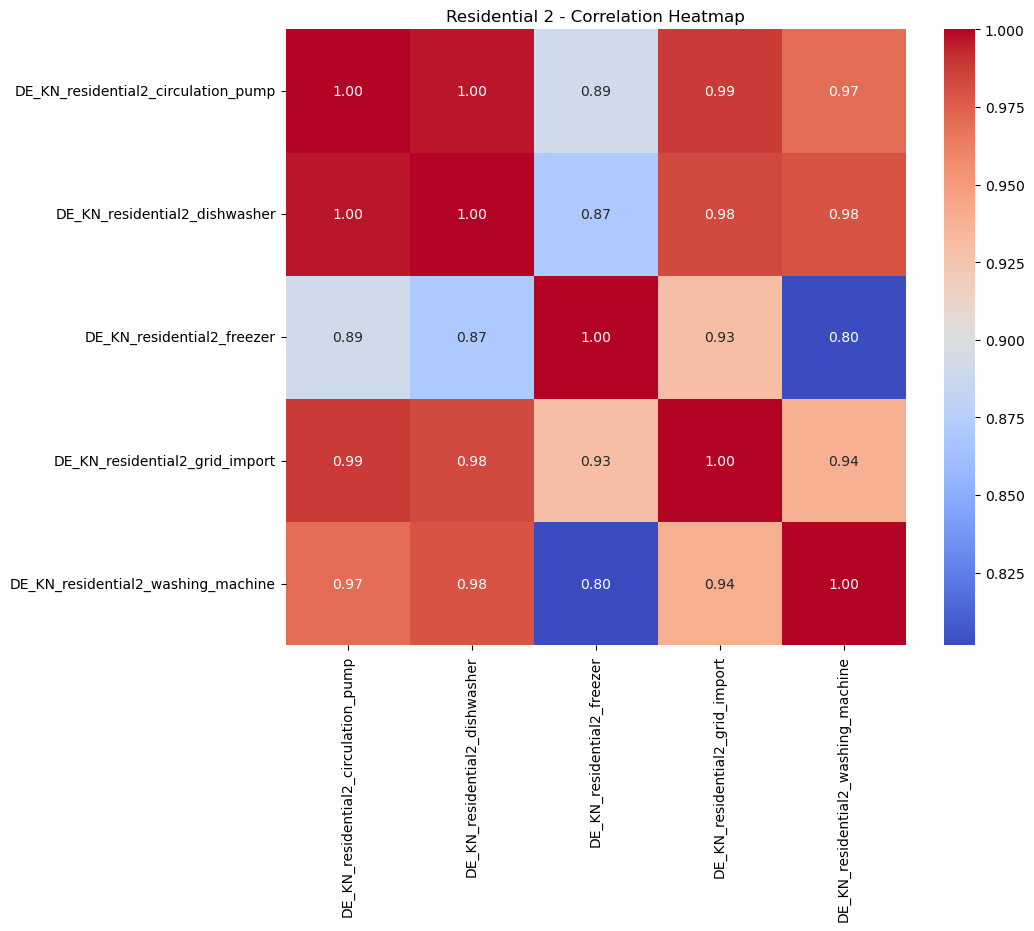

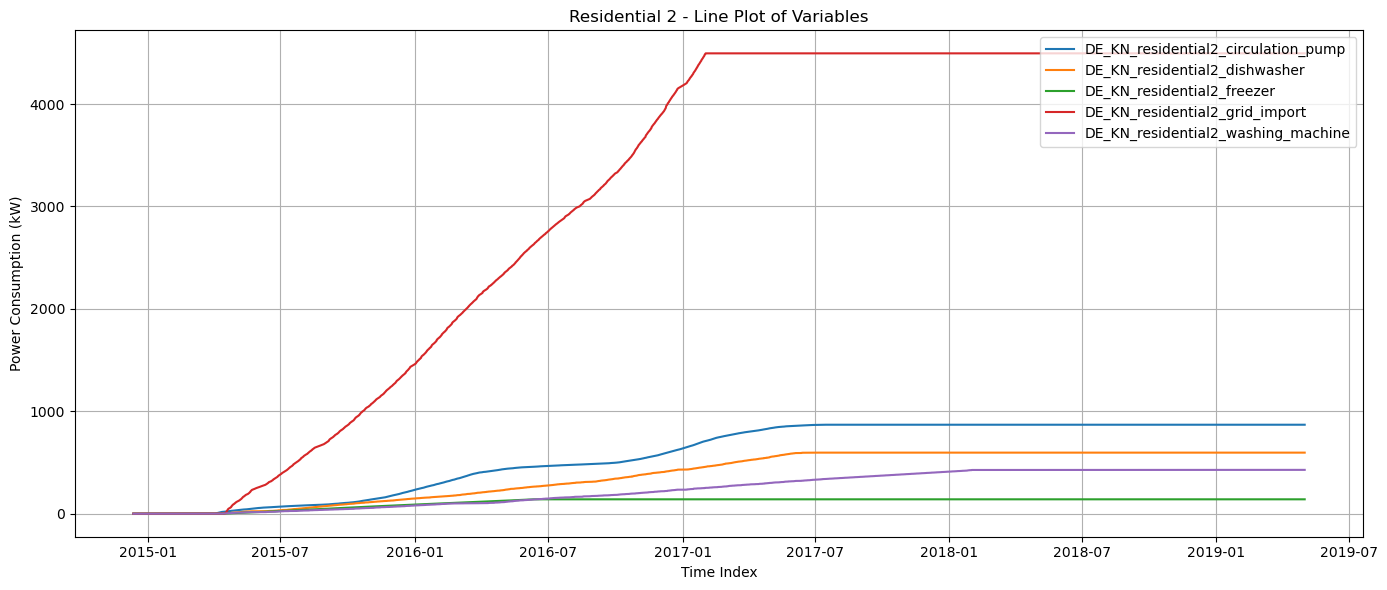

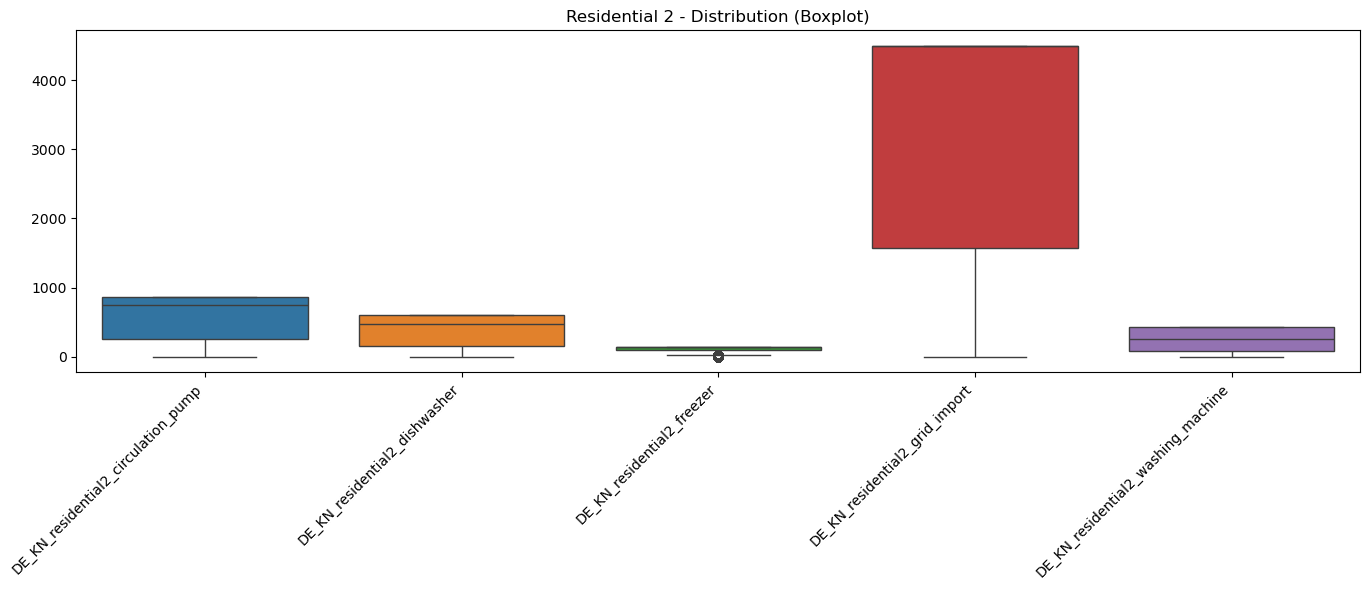

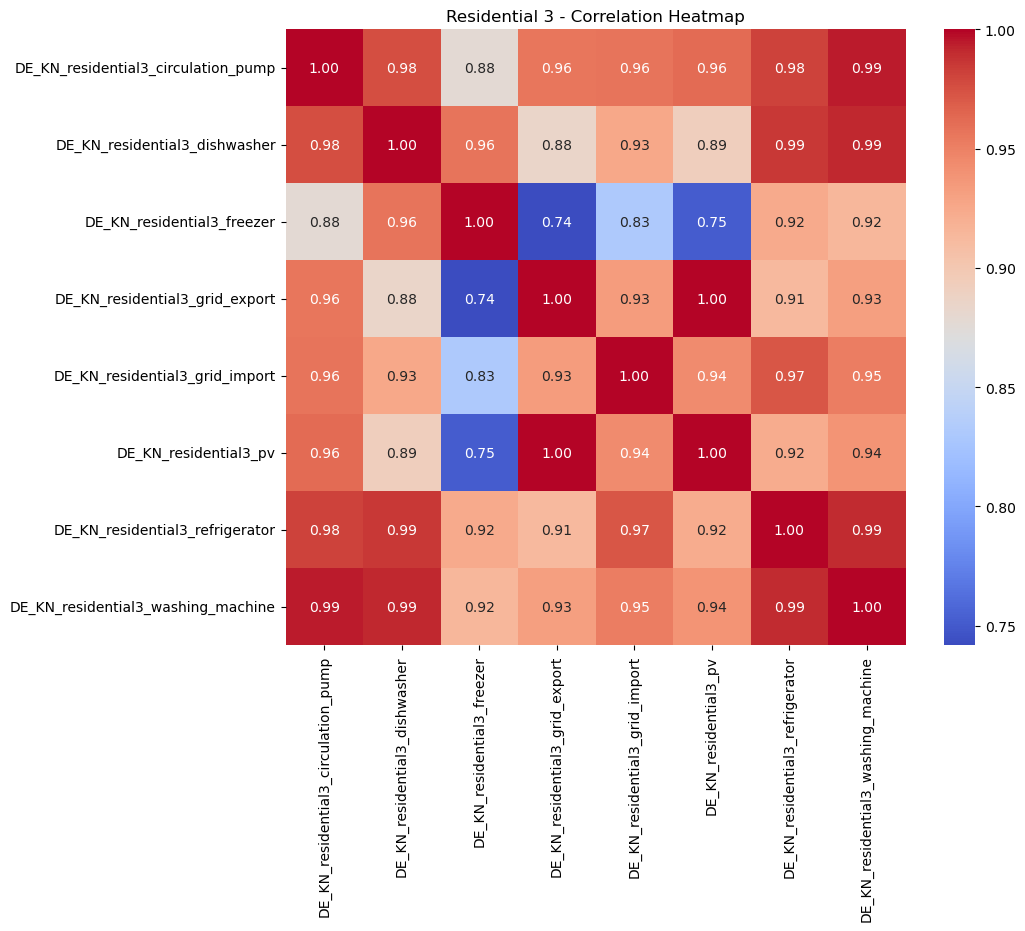

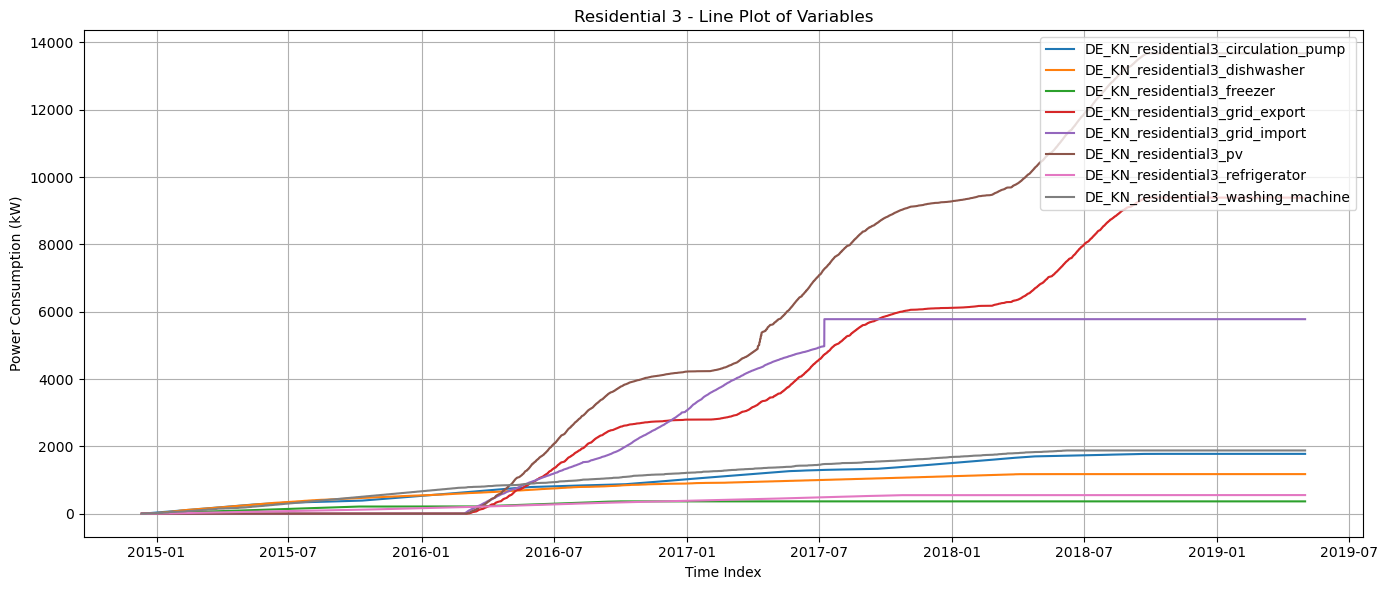

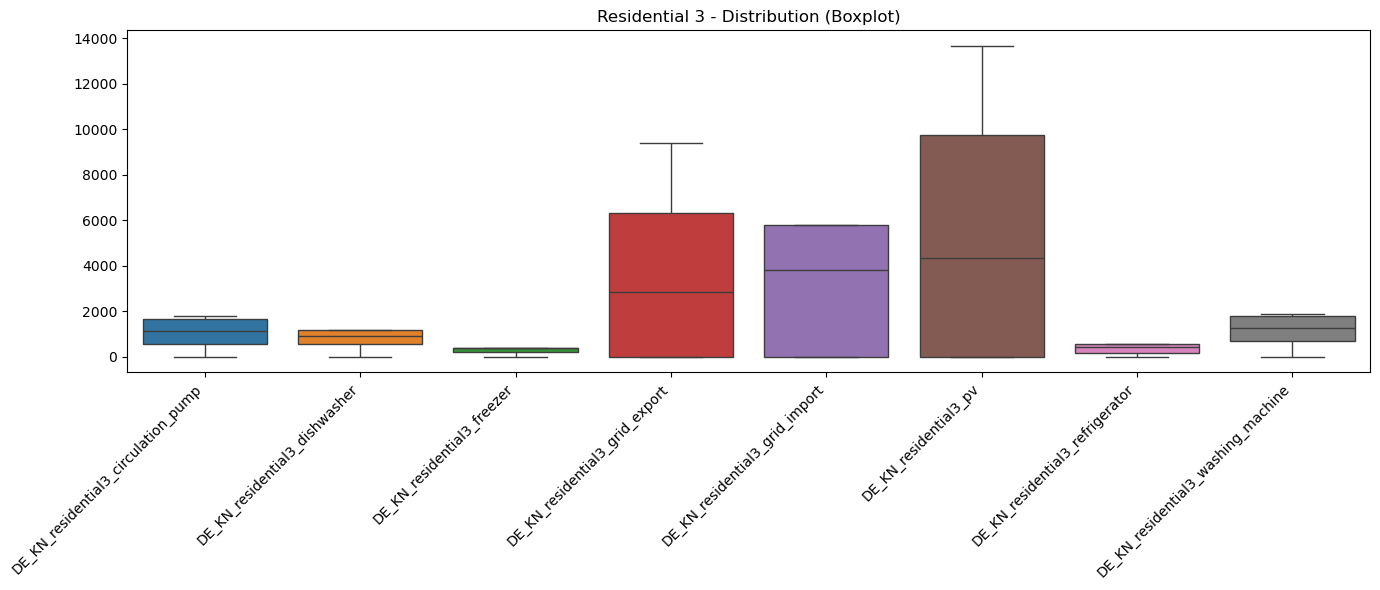

In [102]:
# Function for heatmap and line plots
def plot_heatmap_and_lines(df, title_prefix):
    # Correlation Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(f"{title_prefix} - Correlation Heatmap")
    plt.show()

    # Line plots for each variable over time (assuming index is time-like)
    plt.figure(figsize=(14, 6))
    for col in df.columns:
        plt.plot(df.index, df[col], label=col)
    plt.title(f"{title_prefix} - Line Plot of Variables")
    plt.xlabel("Time Index")
    plt.ylabel("Power Consumption (kW)")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Boxplot for variable distributions
    plt.figure(figsize=(14, 6))
    sns.boxplot(data=df)
    plt.title(f"{title_prefix} - Distribution (Boxplot)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Example calls
plot_heatmap_and_lines(df_residential1, "Residential 1")
plot_heatmap_and_lines(df_residential2, "Residential 2")
plot_heatmap_and_lines(df_residential3, "Residential 3")


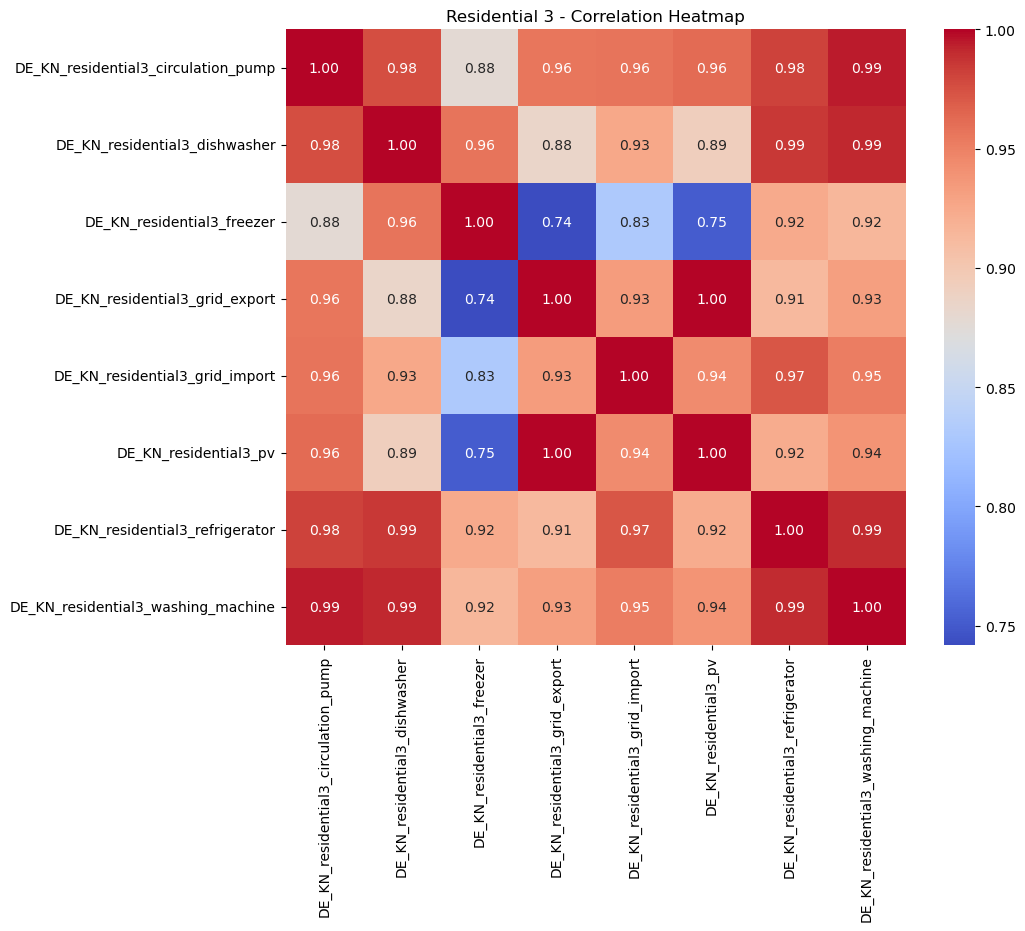

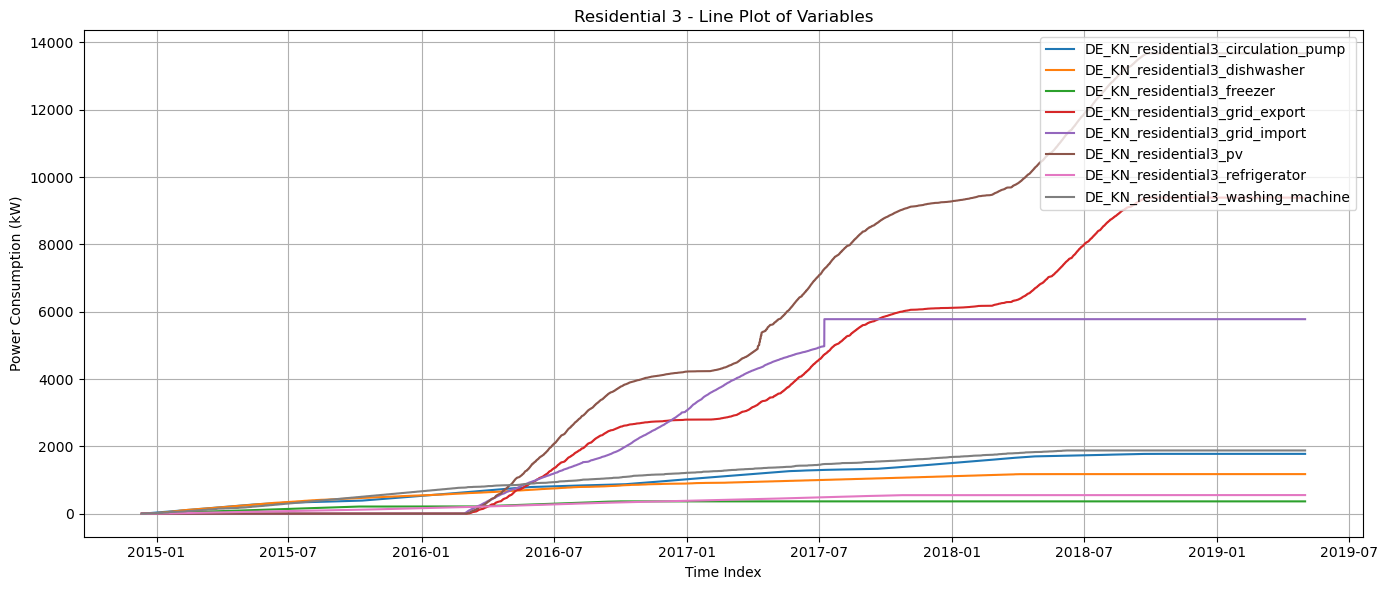

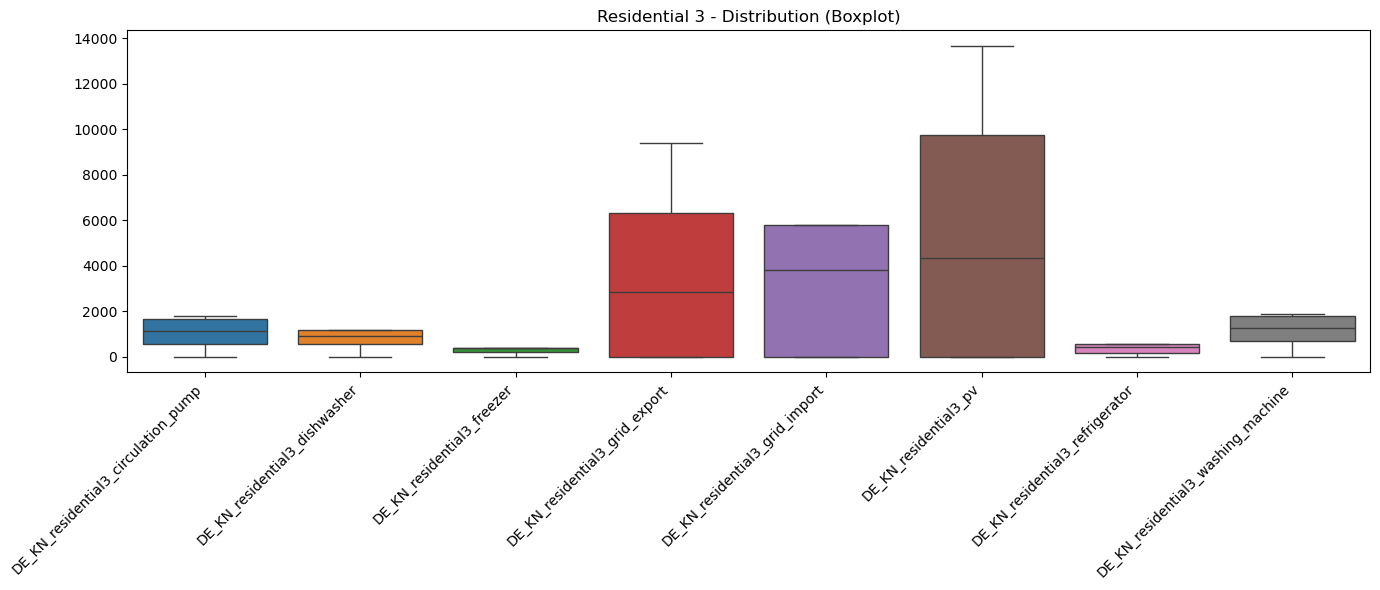

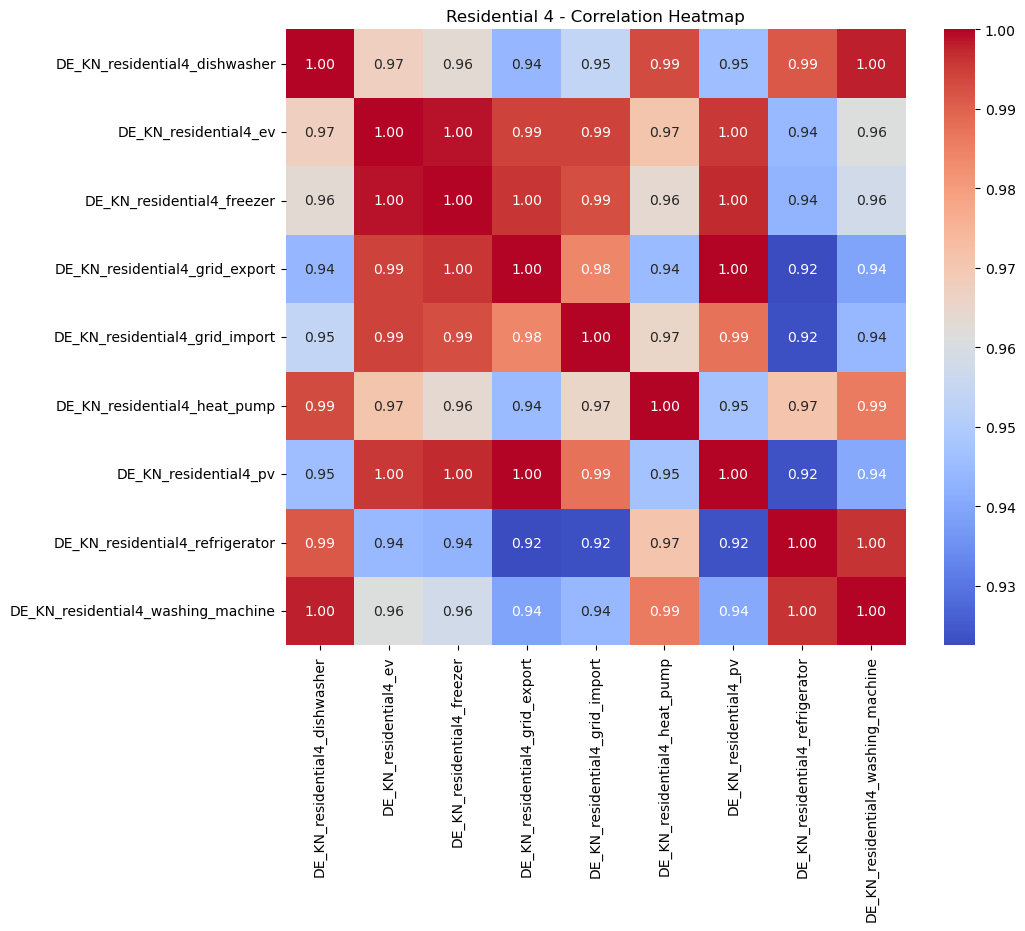

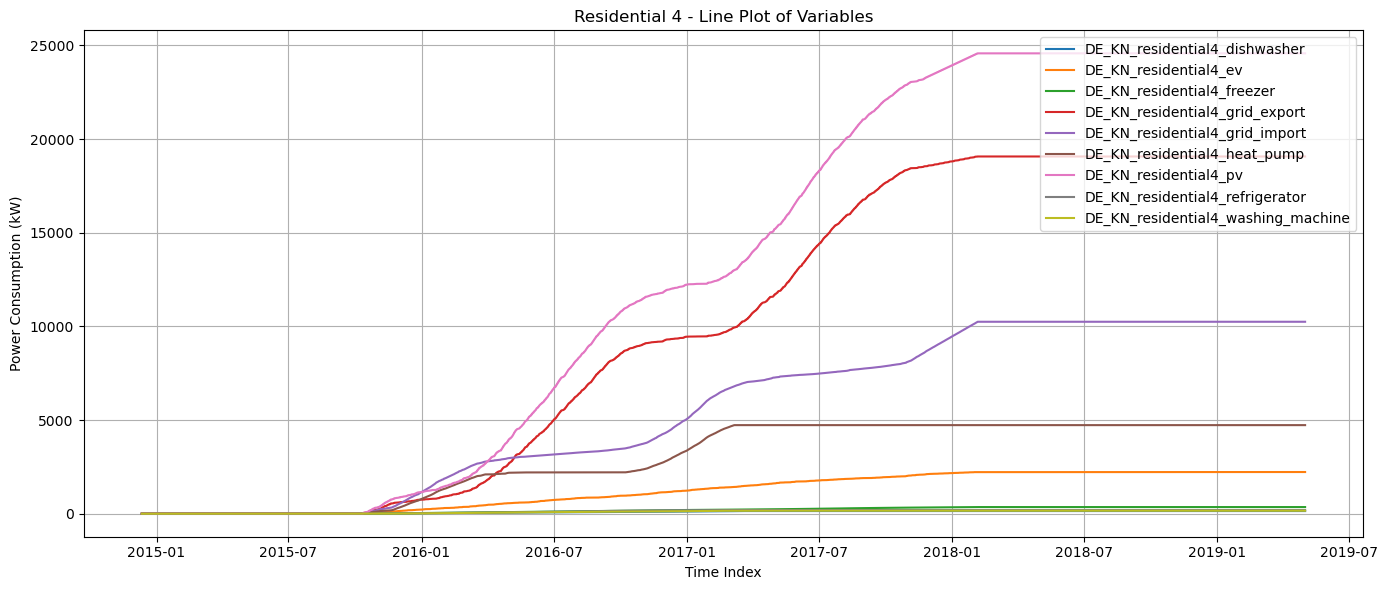

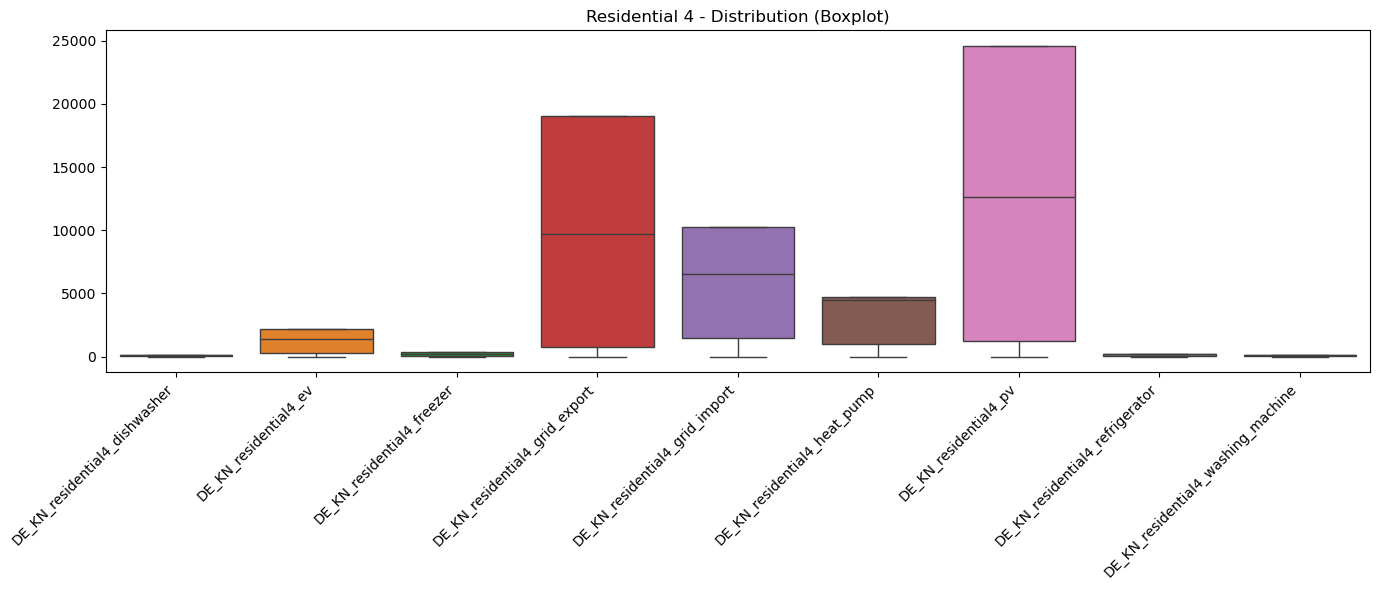

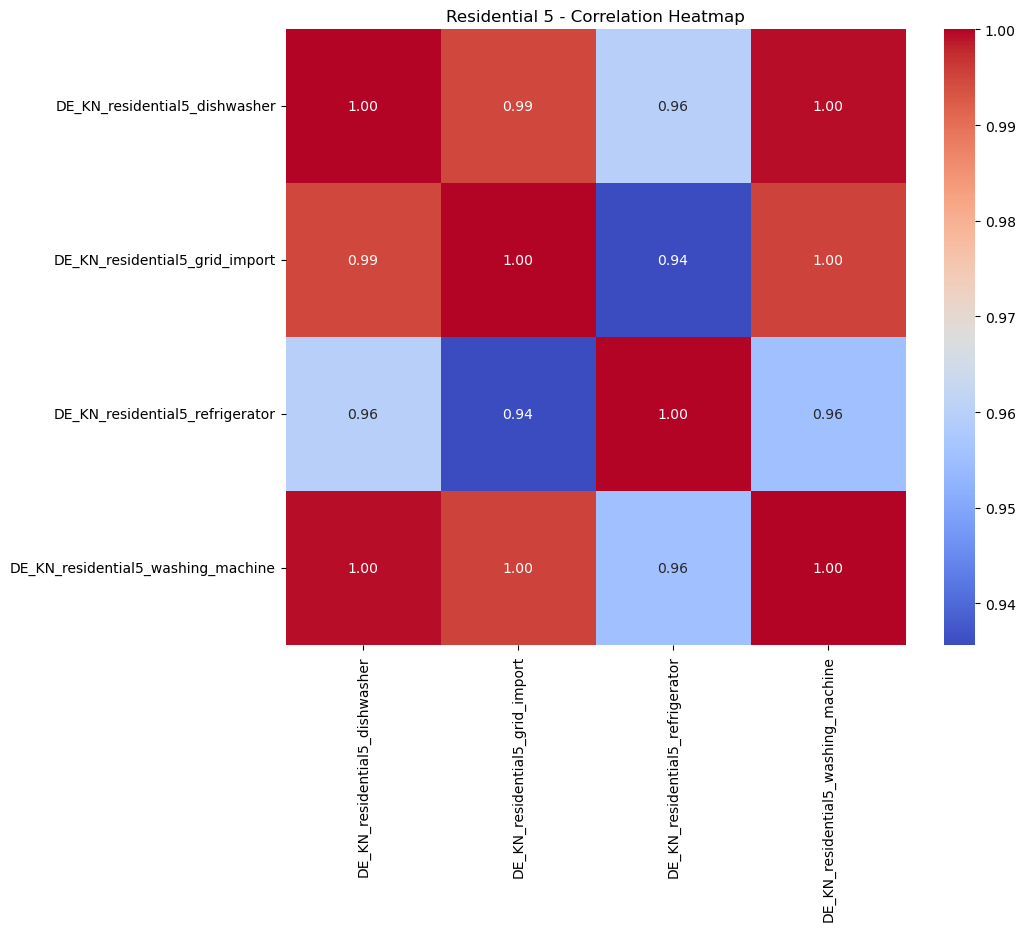

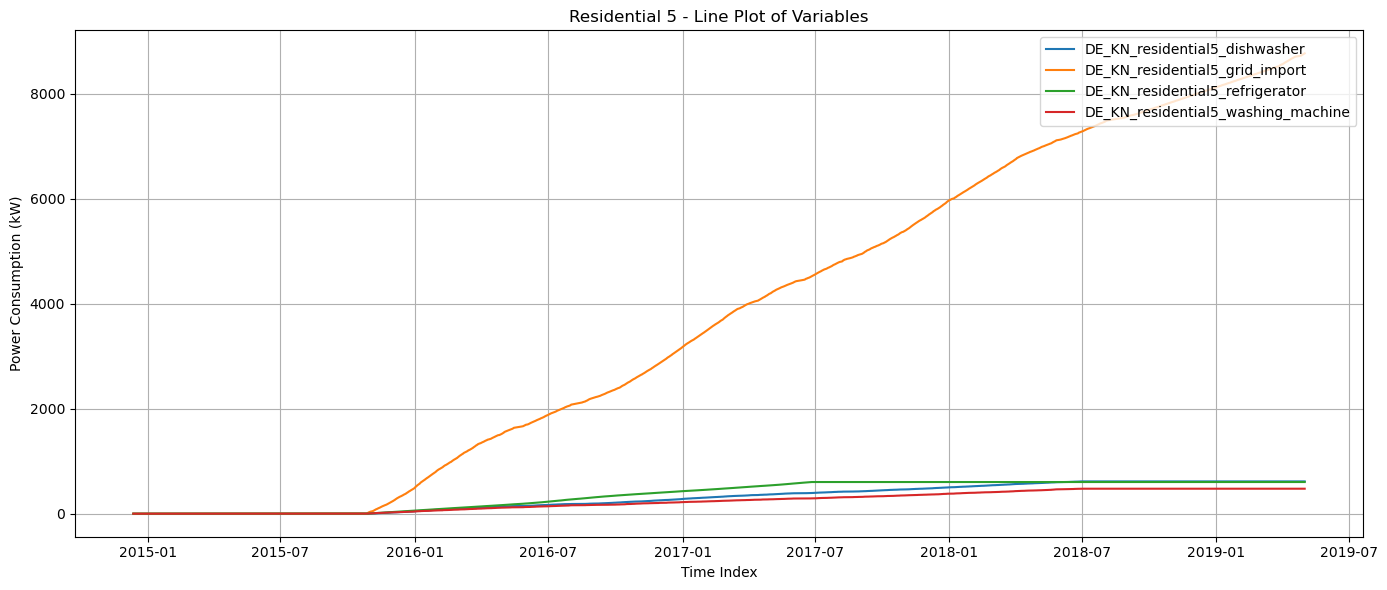

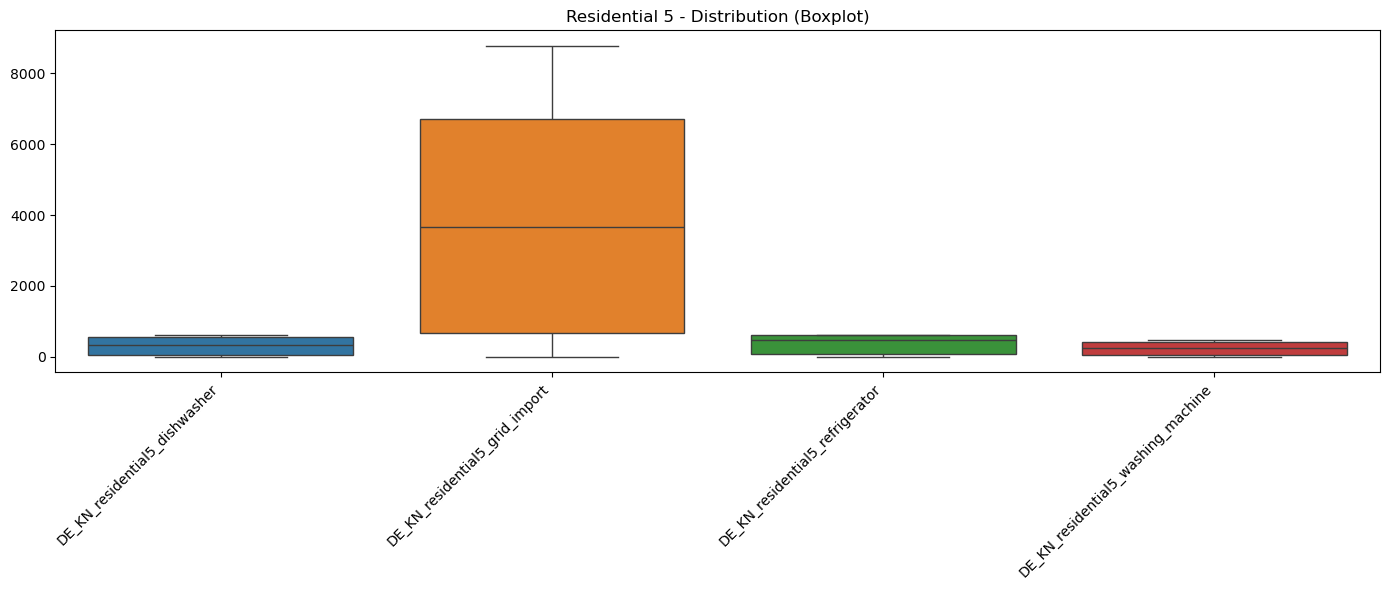

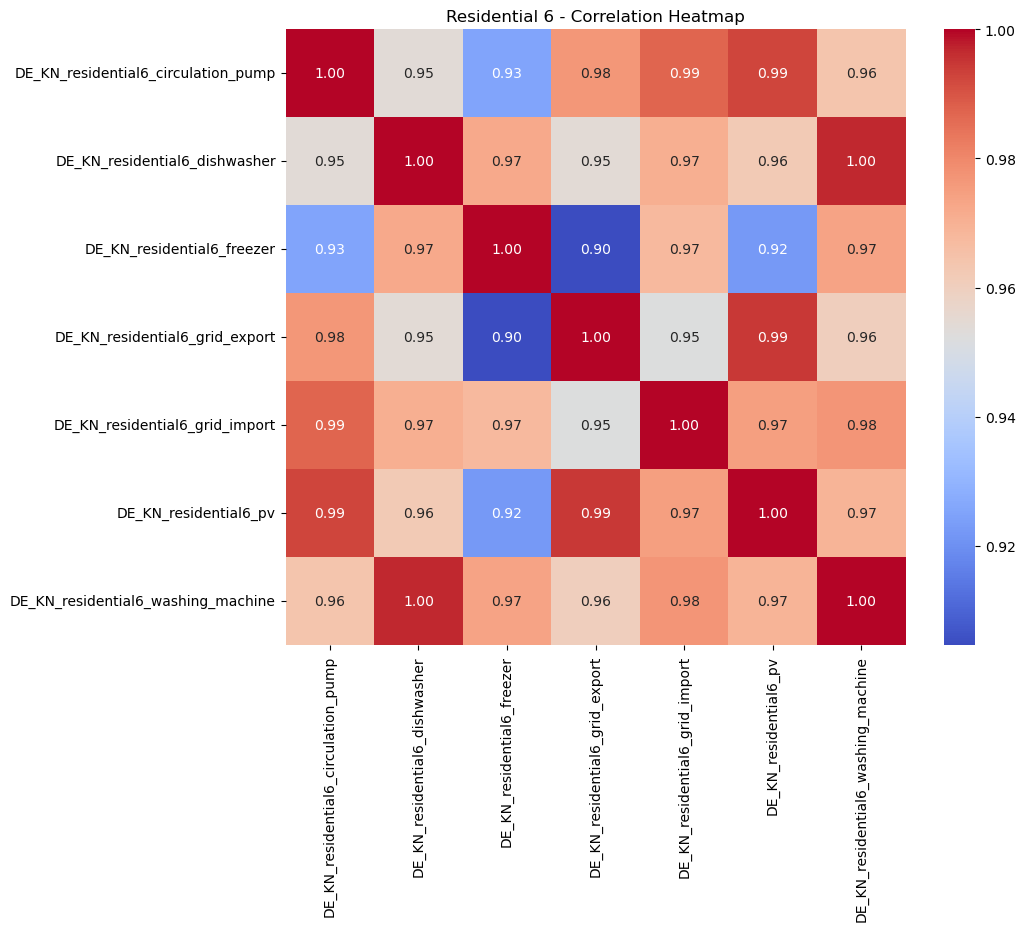

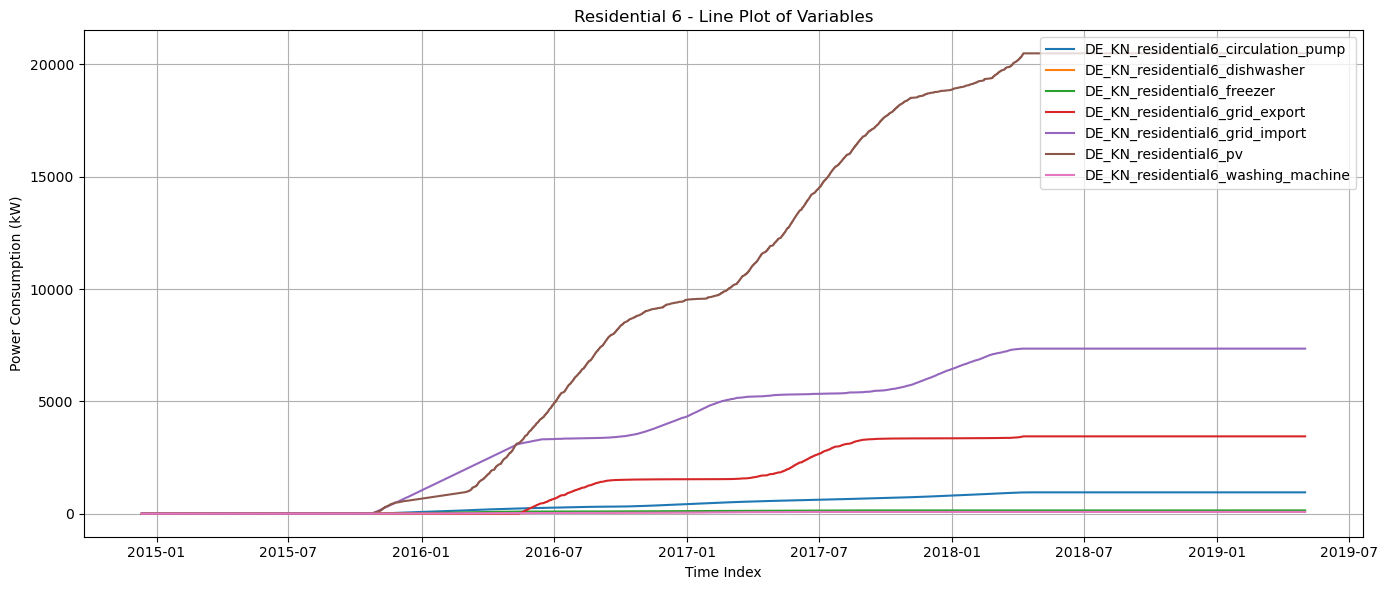

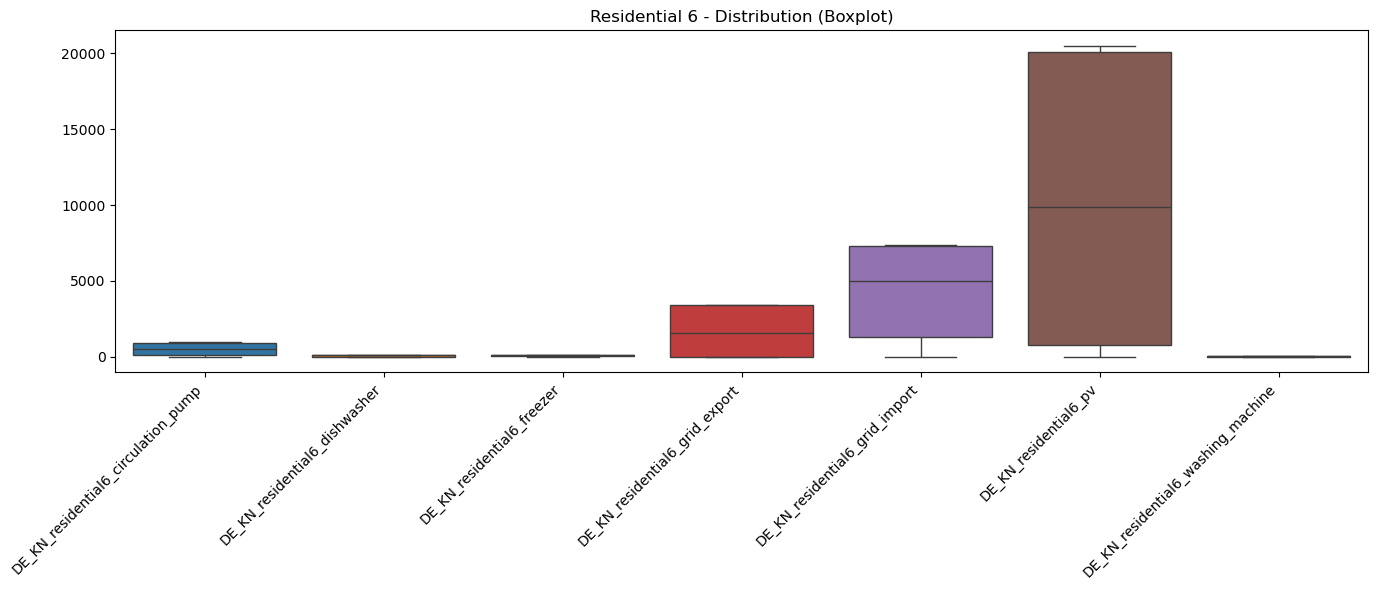

In [104]:

# Function for heatmap, line plot, and boxplot
def plot_heatmap_and_lines(df, title_prefix):
    # Correlation Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(f"{title_prefix} - Correlation Heatmap")
    plt.show()

    # Line plots for each variable over time (assuming index is time-like)
    plt.figure(figsize=(14, 6))
    for col in df.columns:
        plt.plot(df.index, df[col], label=col)
    plt.title(f"{title_prefix} - Line Plot of Variables")
    plt.xlabel("Time Index")
    plt.ylabel("Power Consumption (kW)")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Boxplot for variable distributions
    plt.figure(figsize=(14, 6))
    sns.boxplot(data=df)
    plt.title(f"{title_prefix} - Distribution (Boxplot)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Example calls for Residential 3, 4, 5, 6
plot_heatmap_and_lines(df_residential3, "Residential 3")
plot_heatmap_and_lines(df_residential4, "Residential 4")
plot_heatmap_and_lines(df_residential5, "Residential 5")
plot_heatmap_and_lines(df_residential6, "Residential 6")



In [66]:
print(df.head())  # Inspect the first few rows to see if data is loaded correctly


Empty DataFrame
Columns: [DE_KN_industrial1_grid_import, DE_KN_industrial1_pv_1, DE_KN_industrial1_pv_2, DE_KN_industrial2_grid_import, DE_KN_industrial2_pv, DE_KN_industrial2_storage_charge, DE_KN_industrial2_storage_decharge, DE_KN_industrial3_area_offices, DE_KN_industrial3_area_room_1, DE_KN_industrial3_area_room_2, DE_KN_industrial3_area_room_3, DE_KN_industrial3_area_room_4, DE_KN_industrial3_compressor, DE_KN_industrial3_cooling_aggregate, DE_KN_industrial3_cooling_pumps, DE_KN_industrial3_dishwasher, DE_KN_industrial3_ev, DE_KN_industrial3_grid_import, DE_KN_industrial3_machine_1, DE_KN_industrial3_machine_2, DE_KN_industrial3_machine_3, DE_KN_industrial3_machine_4, DE_KN_industrial3_machine_5, DE_KN_industrial3_pv_facade, DE_KN_industrial3_pv_roof, DE_KN_industrial3_refrigerator, DE_KN_industrial3_ventilation, DE_KN_public1_grid_import, DE_KN_public2_grid_import, DE_KN_residential1_dishwasher, DE_KN_residential1_freezer, DE_KN_residential1_grid_import, DE_KN_residential1_heat_

In [64]:
print("Original DataFrame shape:", df.shape)
print("Missing values per column in the original DataFrame:")
print(df.isna().sum())


Original DataFrame shape: (0, 80)
Missing values per column in the original DataFrame:
DE_KN_industrial1_grid_import                    0
DE_KN_industrial1_pv_1                           0
DE_KN_industrial1_pv_2                           0
DE_KN_industrial2_grid_import                    0
DE_KN_industrial2_pv                             0
                                                ..
DE_KN_residential4_grid_import_rolling_mean_6    0
DE_KN_residential4_grid_import_rolling_std_6     0
hour                                             0
dayofweek                                        0
month                                            0
Length: 80, dtype: int64


In [88]:
# Convert 'utc_timestamp' column to datetime
if 'utc_timestamp' in X_train.columns:
    X_train['utc_timestamp'] = pd.to_datetime(X_train['utc_timestamp'], errors='coerce')
    X_train['hour_utc'] = X_train['utc_timestamp'].dt.hour
    X_train['day_utc'] = X_train['utc_timestamp'].dt.day
    X_train['month_utc'] = X_train['utc_timestamp'].dt.month
    X_train.drop(columns=['utc_timestamp'], inplace=True)

# Convert 'cet_cest_timestamp' to datetime with utc=True to handle mixed time zones
if 'cet_cest_timestamp' in X_train.columns:
    X_train['cet_cest_timestamp'] = pd.to_datetime(X_train['cet_cest_timestamp'], errors='coerce', utc=True)
    X_train['hour_cet'] = X_train['cet_cest_timestamp'].dt.hour
    X_train['day_cet'] = X_train['cet_cest_timestamp'].dt.day
    X_train['month_cet'] = X_train['cet_cest_timestamp'].dt.month
    X_train.drop(columns=['cet_cest_timestamp'], inplace=True)

# Convert 'interpolated' column (if categorical) to numeric
if 'interpolated' in X_train.columns:
    X_train['interpolated'] = X_train['interpolated'].astype('category').cat.codes

# Verify data types again
print(X_train.dtypes)

# Fit the model again
model.fit(X_train, y_train)


DE_KN_industrial1_grid_import    float64
DE_KN_industrial1_pv_1           float64
DE_KN_industrial1_pv_2           float64
DE_KN_industrial2_grid_import    float64
DE_KN_industrial2_pv             float64
                                  ...   
day_utc                            int32
month_utc                          int32
hour_cet                           int32
day_cet                            int32
month_cet                          int32
Length: 74, dtype: object
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17314
[LightGBM] [Info] Number of data points in the train set: 123048, number of used features: 74
[LightGBM] [Info] Start training from score 5526.989376


LGBMRegressor(learning_rate=0.05, n_estimators=1000, random_state=42)

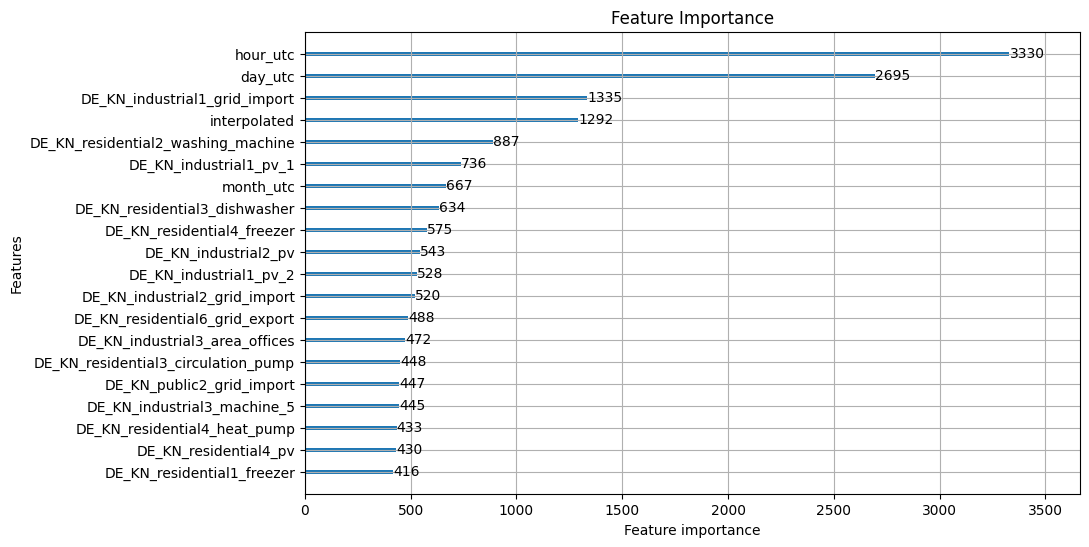

In [90]:
import lightgbm as lgb

# Plot feature importance
lgb.plot_importance(model, importance_type='split', max_num_features=20, figsize=(10, 6))
plt.title('Feature Importance')
plt.show()

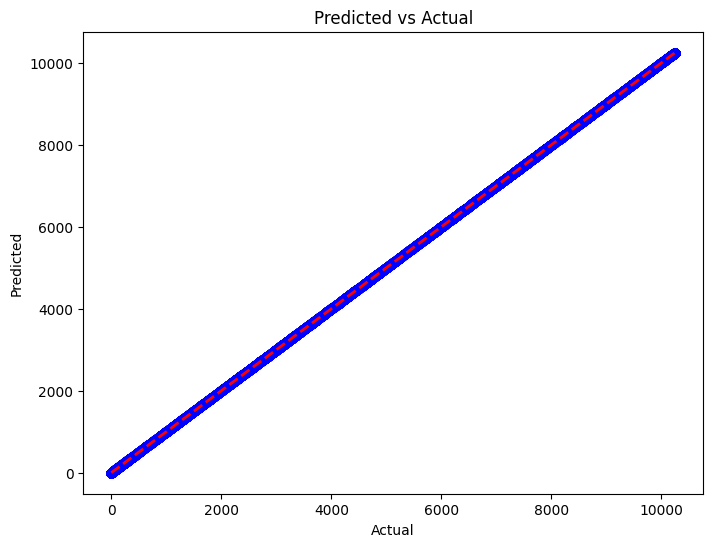

In [92]:
# Make predictions
y_pred = model.predict(X_train)

# Plot predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_pred, alpha=0.5, color='b')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.title('Predicted vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

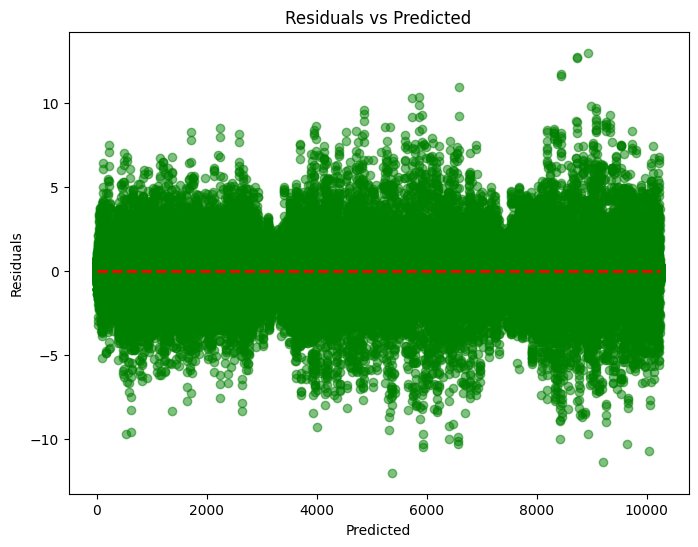

In [94]:
# Calculate residuals
residuals = y_train - y_pred

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5, color='g')
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linestyles='--', lw=2)
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.show()

In [98]:
# Calculate RMSE
from sklearn.metrics import mean_squared_error, r2_score
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
r2 = r2_score(y_train, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared: {r2}')

Root Mean Squared Error (RMSE): 1.2310664226971222
R-squared: 0.9999999069589931
